# Лабораторная работа №1

Выполнил Сердюков Матвей Романович, ББМО-01-23

In [ ]:
url = 'https://github.com/ewatson2/EEL6812_DeepFool_Project'
!git clone $url deepfool
%cd /content/deepfool

Cloning into 'deepfool'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/deepfool


## Global imports

In [ ]:
import numpy as np
import json,torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

## Local imports

In [ ]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

## Seeding

In [ ]:
rand_seed = 23
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## Dataset import

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)
mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])
mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])
mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)),transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True,transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



## Load CIFAR

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)
cifar_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])
cifar_tf_train = transforms.Compose([ transforms.RandomCrop( size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])
cifar_tf_inv = transforms.Compose([ transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize( mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])
cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


## DataLoader configuration

In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Network-In-Network Model robustness to FGSM & DeepFool attacks

In [ ]:
deep_args = [10, 10, 0.02, 50]

fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cpu')))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print()
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


<ipython-input-8-07f18867da5f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cpu

## LeNet Model robustness to FGSM & DeepFool attacks

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print()
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-9-45b7632373d3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('

## LeNet attack example for various `eps` values

results for fsgsm_eps = 0.001:


<ipython-input-11-24a665344e1e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

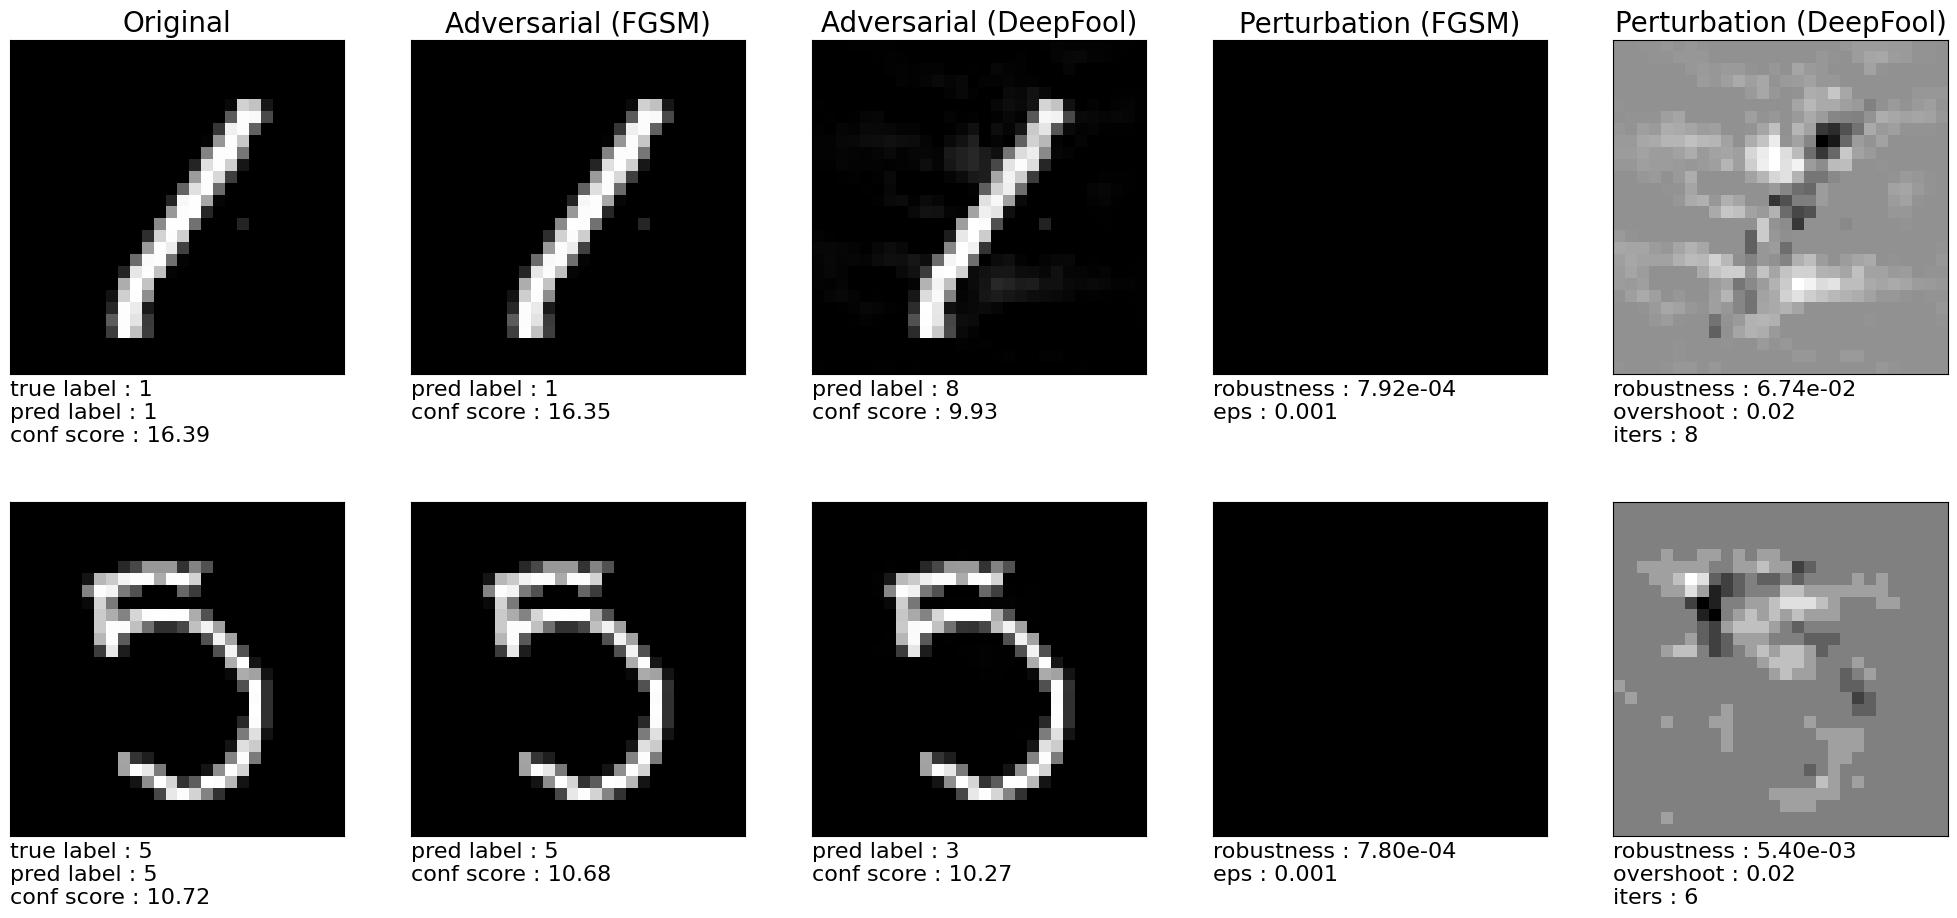

results for fsgsm_eps = 0.02:


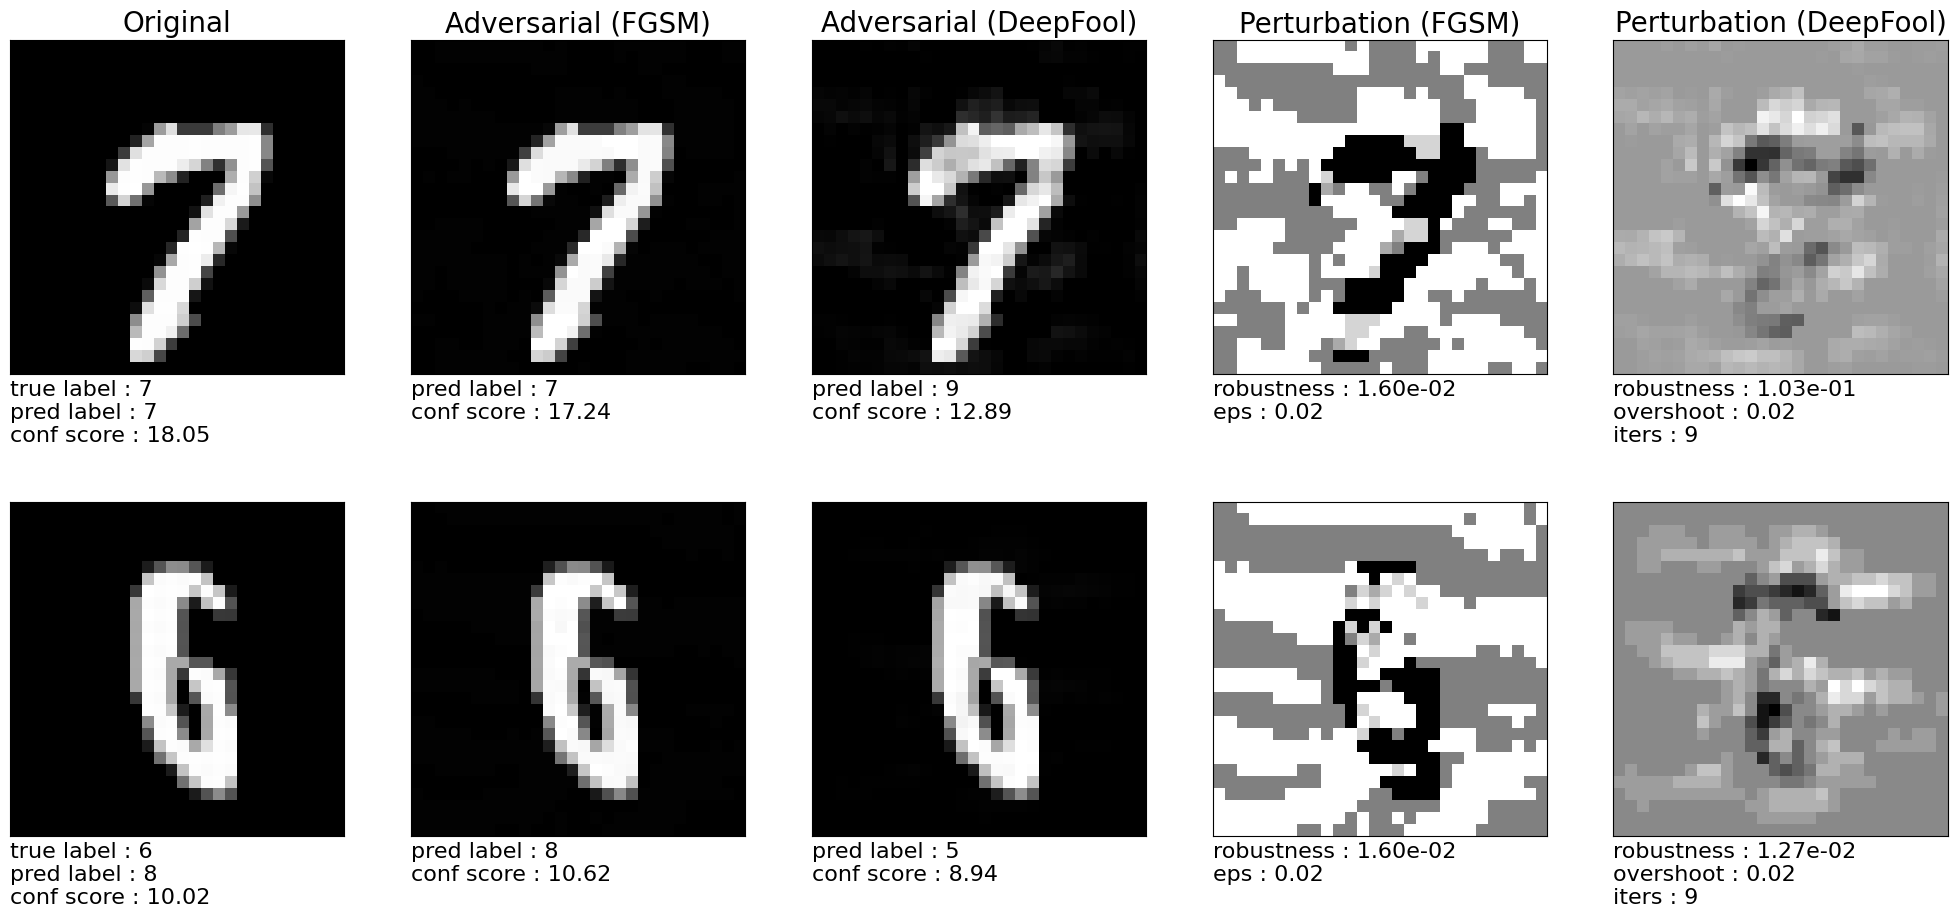

results for fsgsm_eps = 0.5:


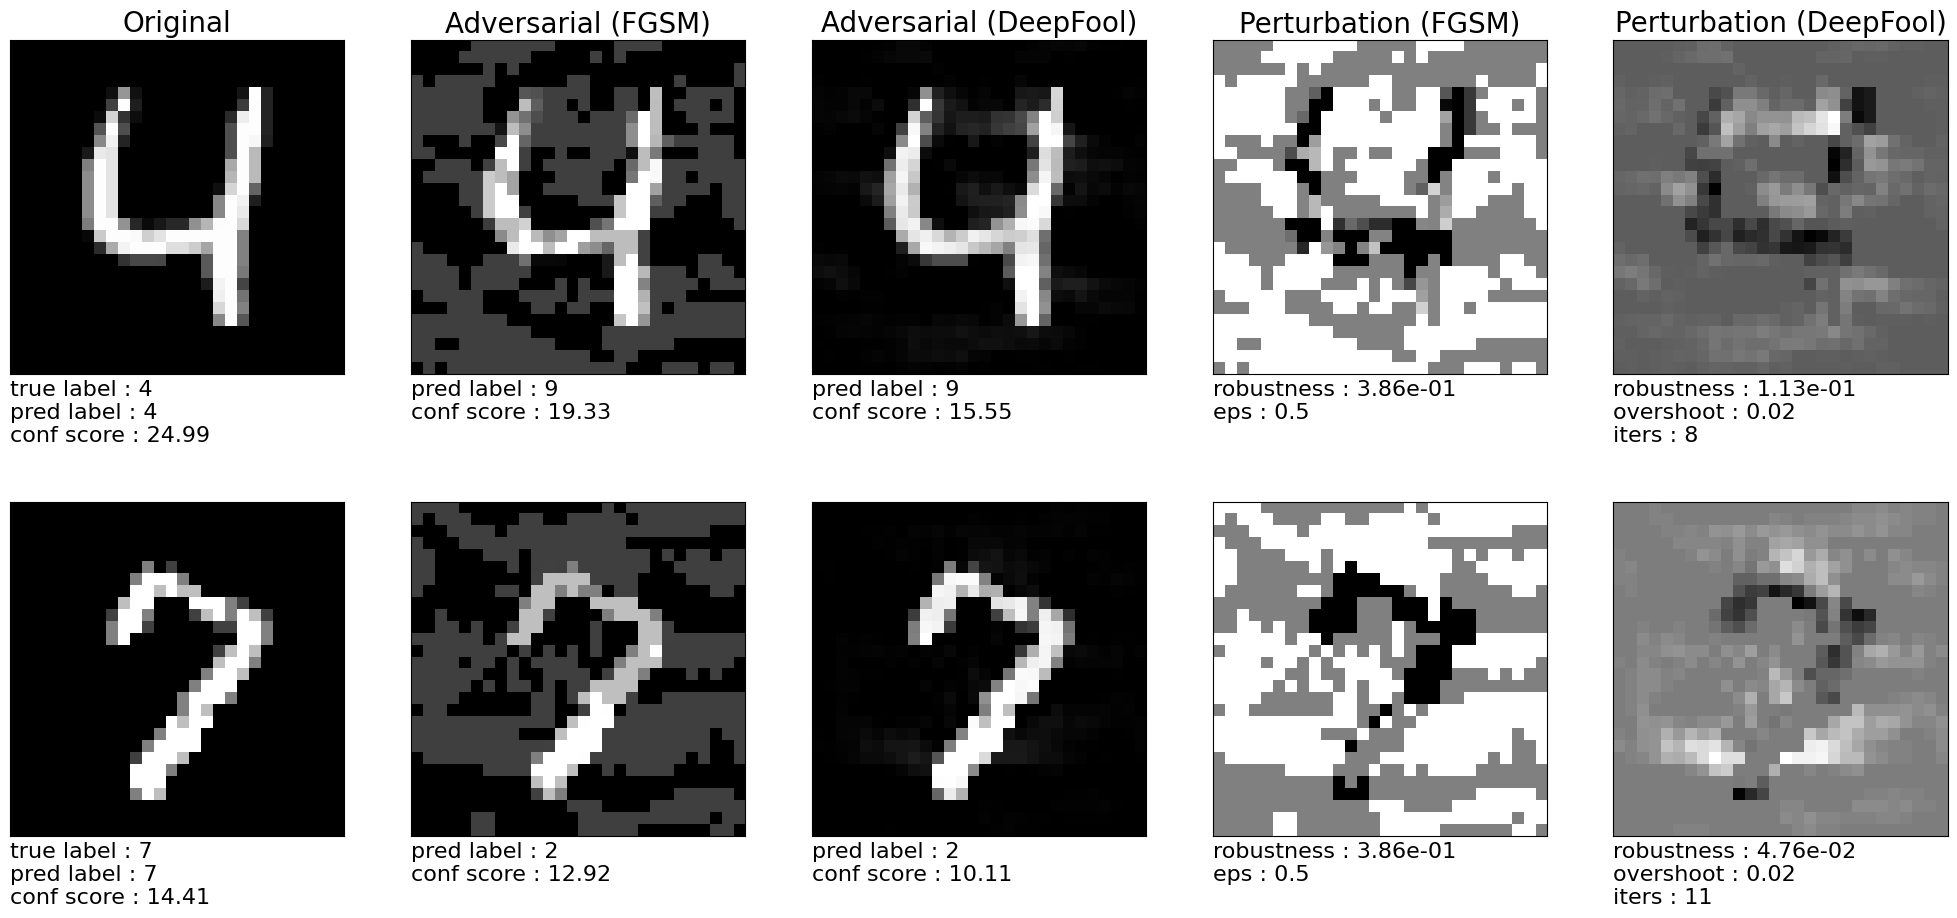

results for fsgsm_eps = 0.9:


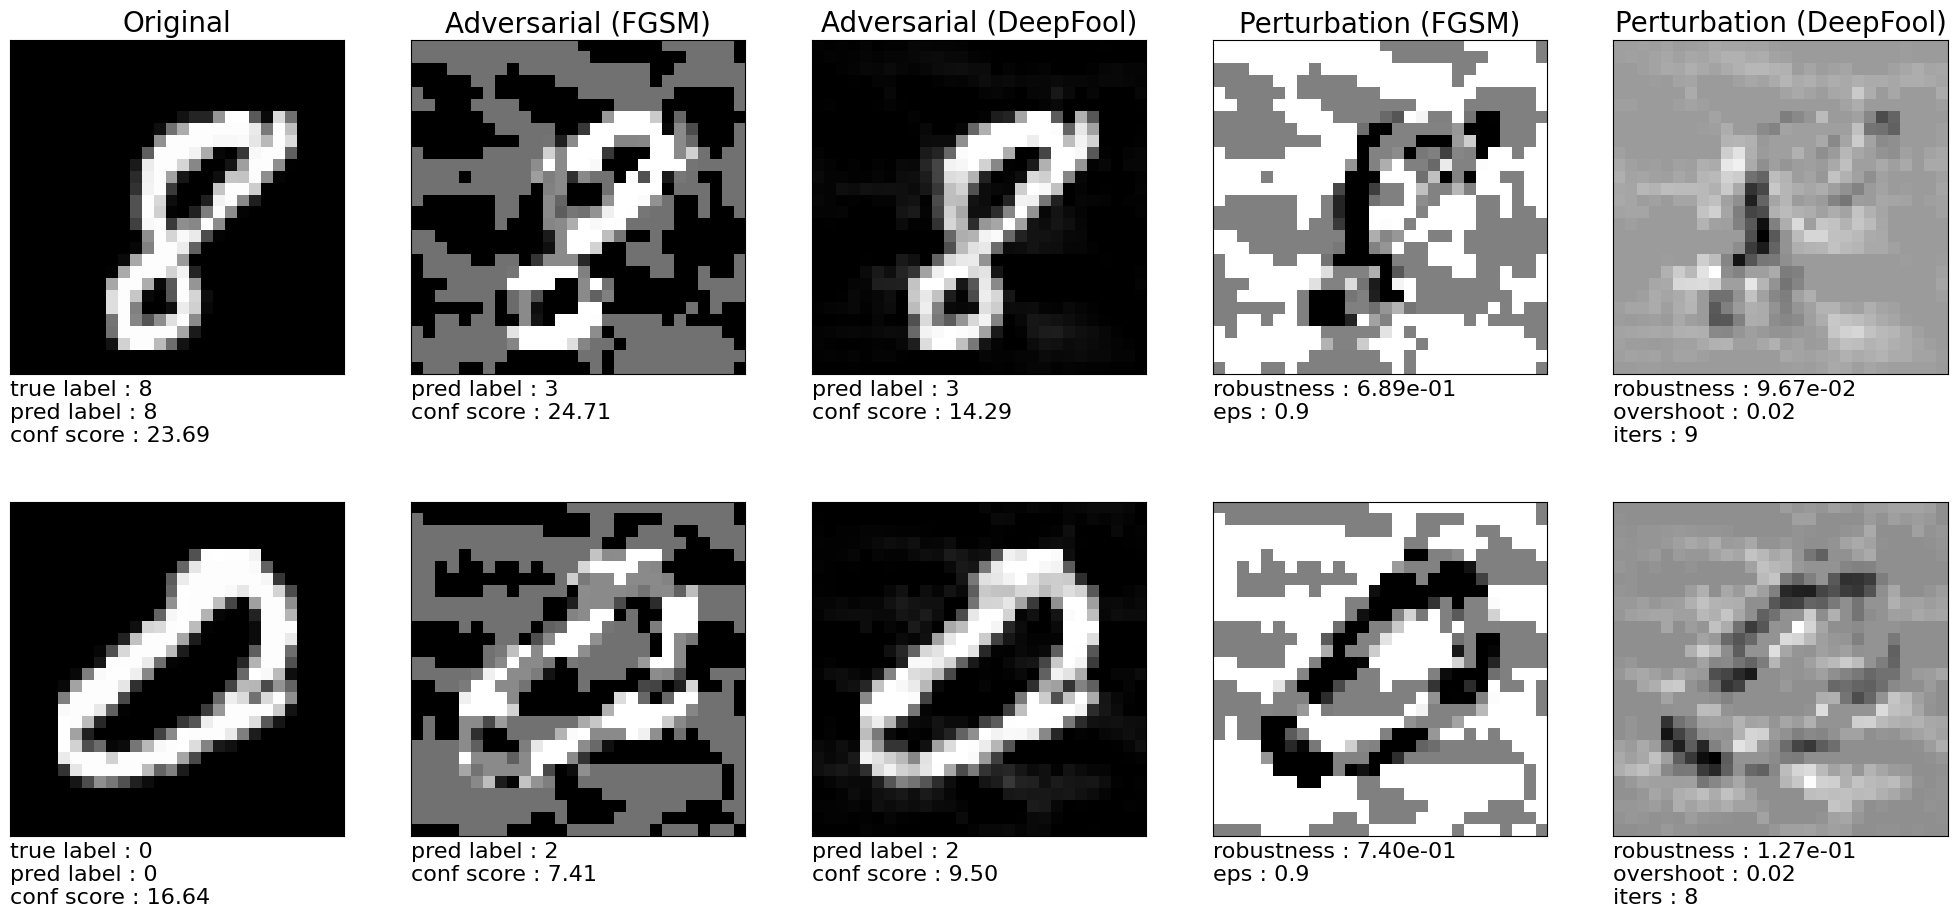

results for fsgsm_eps = 10:


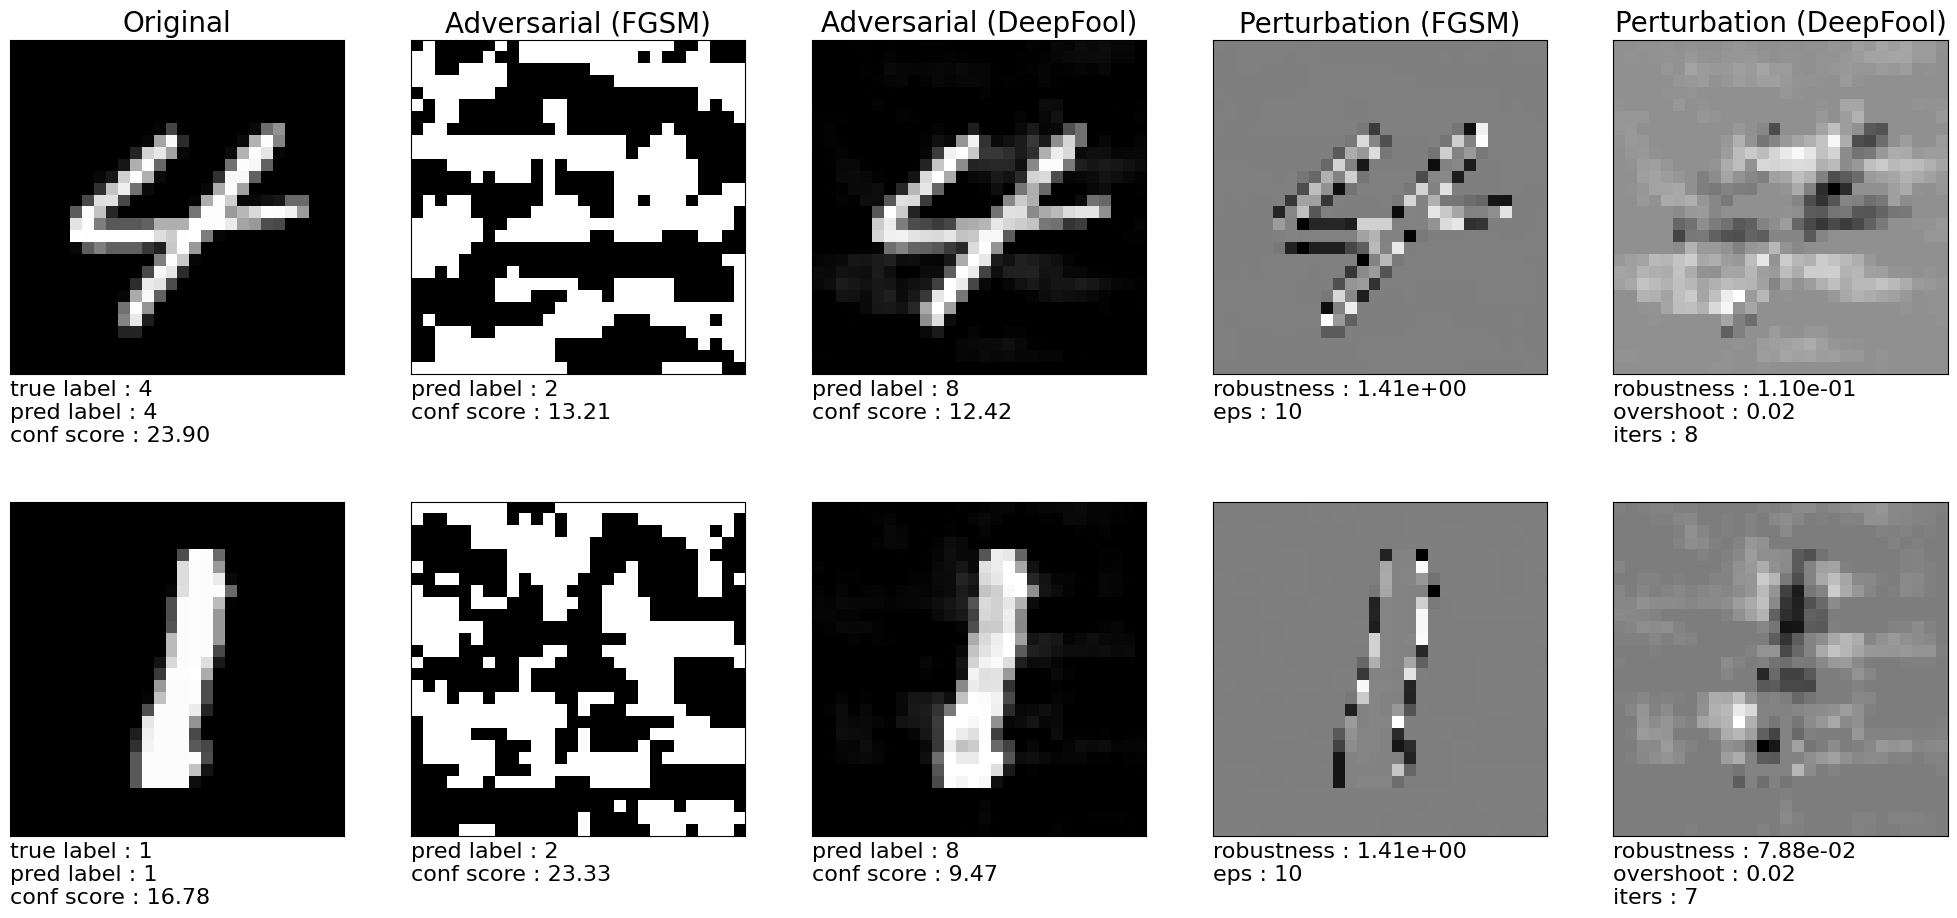

In [ ]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
    print(f"results for fsgsm_eps = {fgsm_eps}:")
    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
    if device.type == 'cuda': torch.cuda.empty_cache()

## FCNet attack example for various `eps` values

results for fsgsm_eps = 0.001:


<ipython-input-12-f377ed2e6179>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


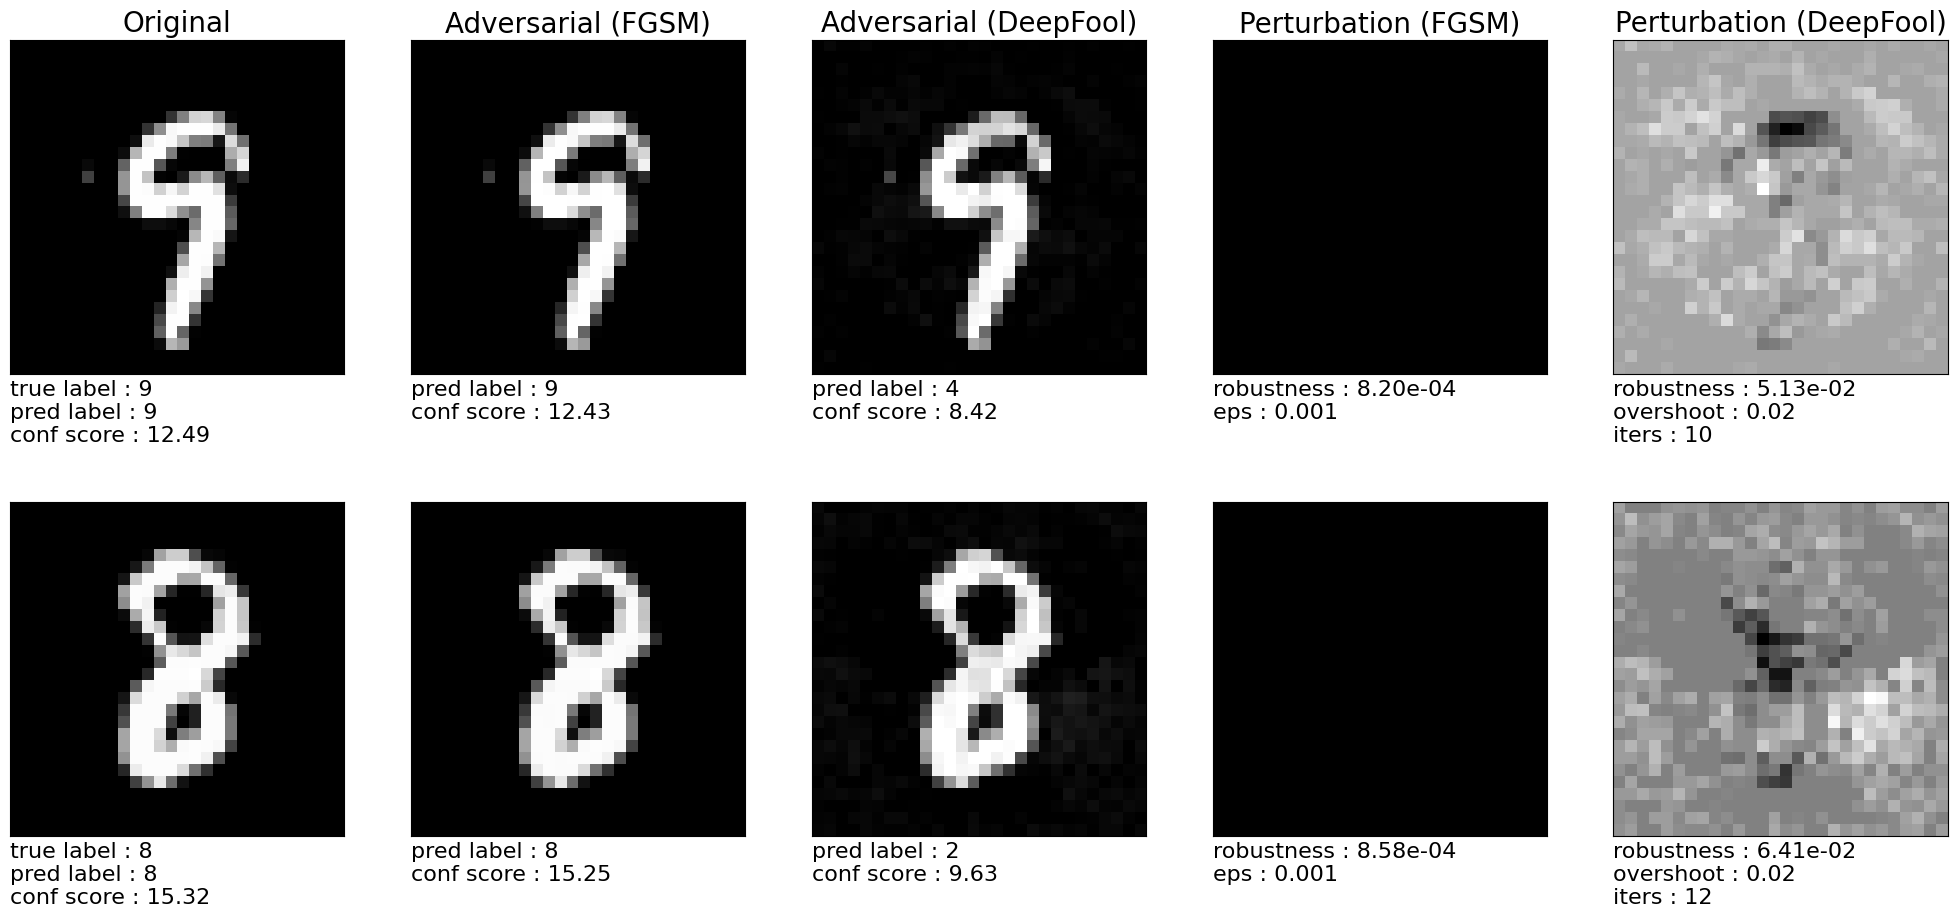

results for fsgsm_eps = 0.02:


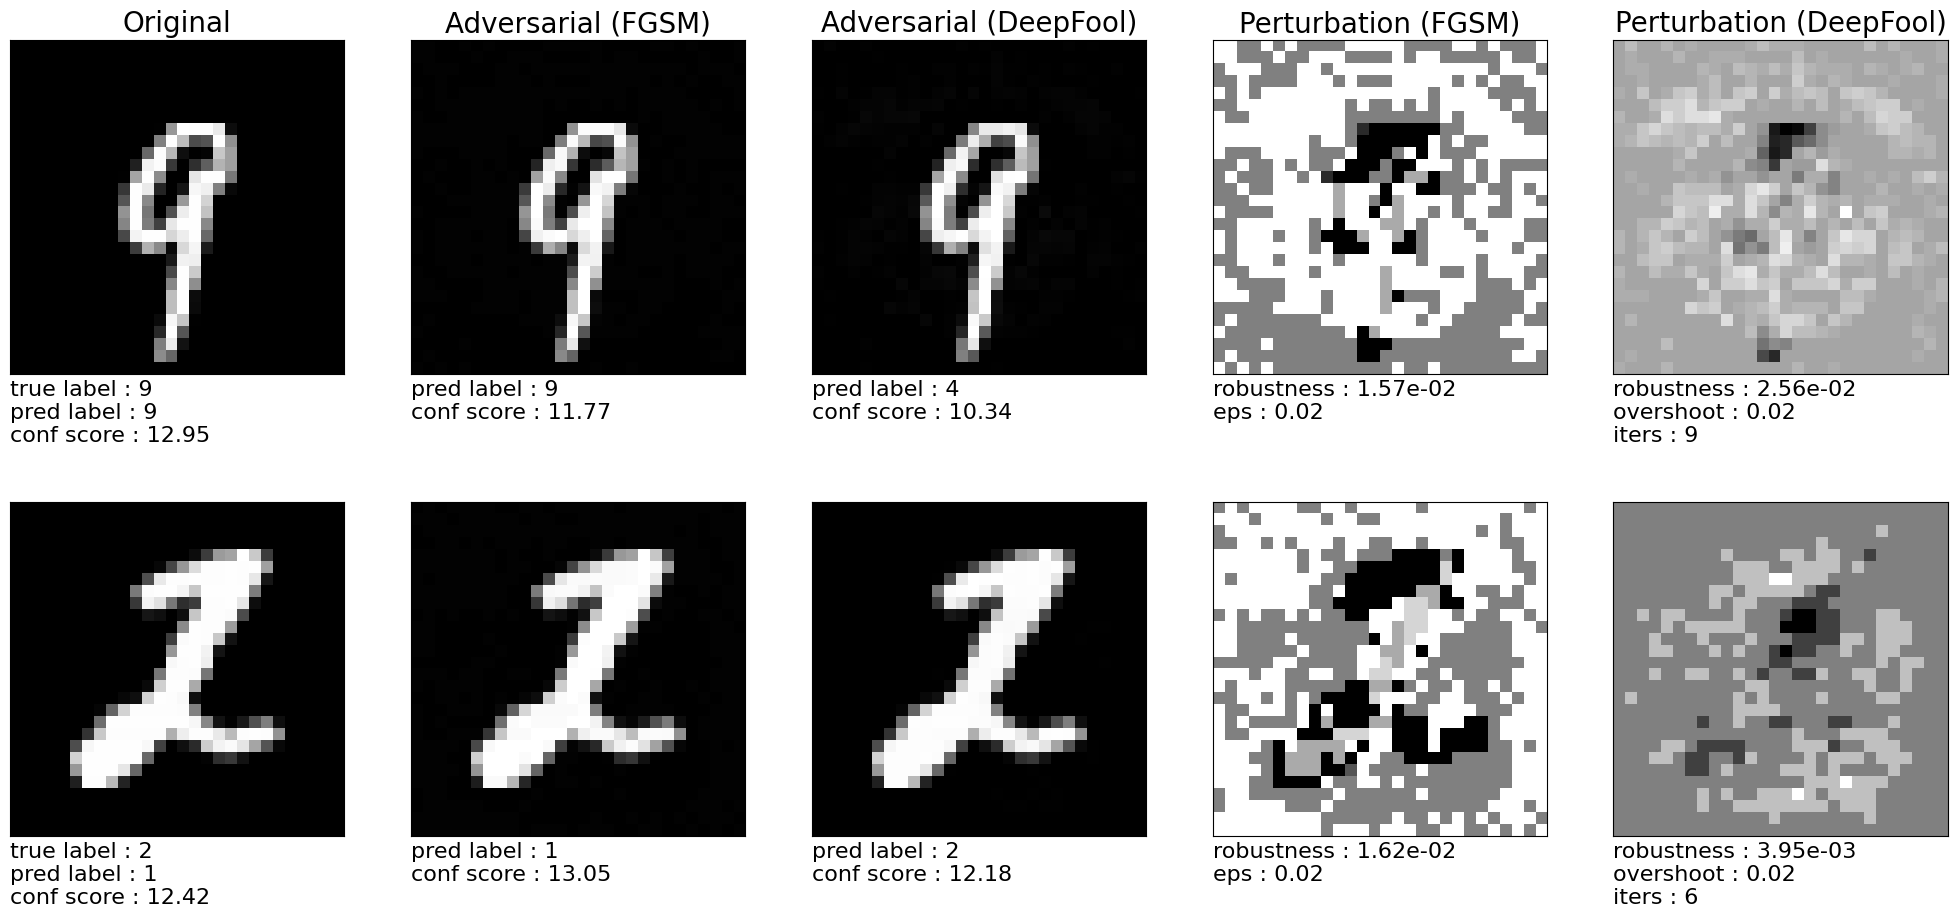

results for fsgsm_eps = 0.5:


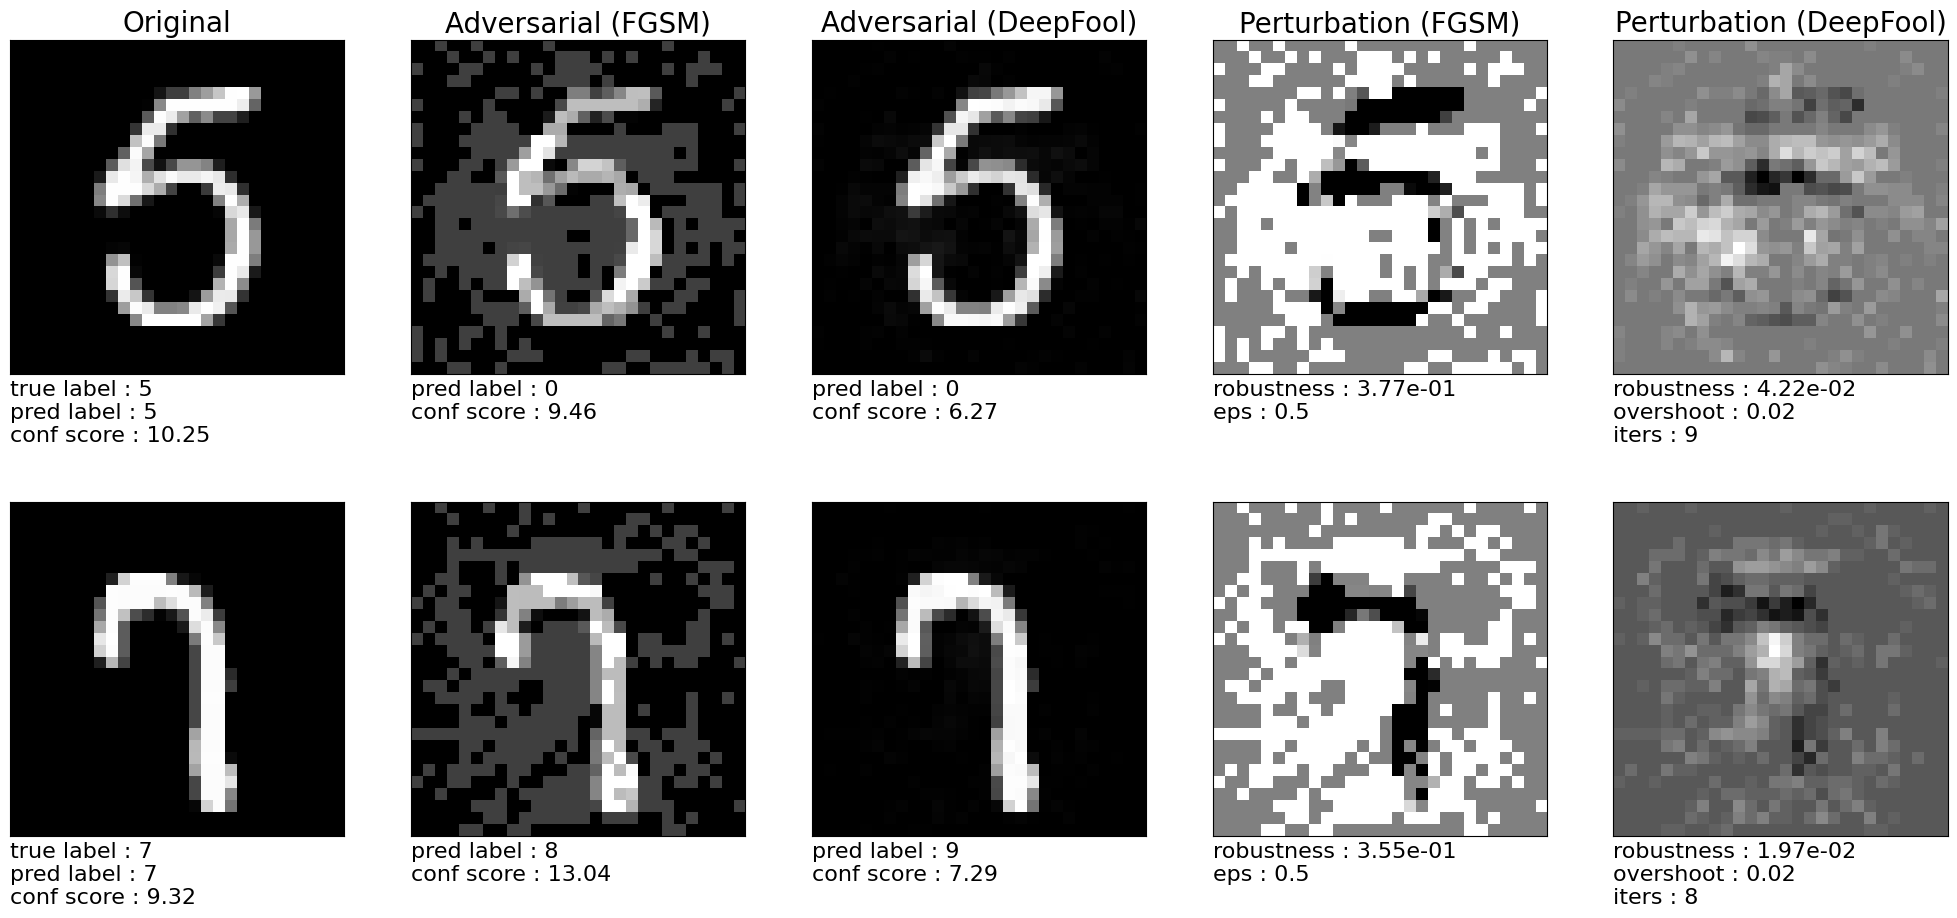

results for fsgsm_eps = 0.9:


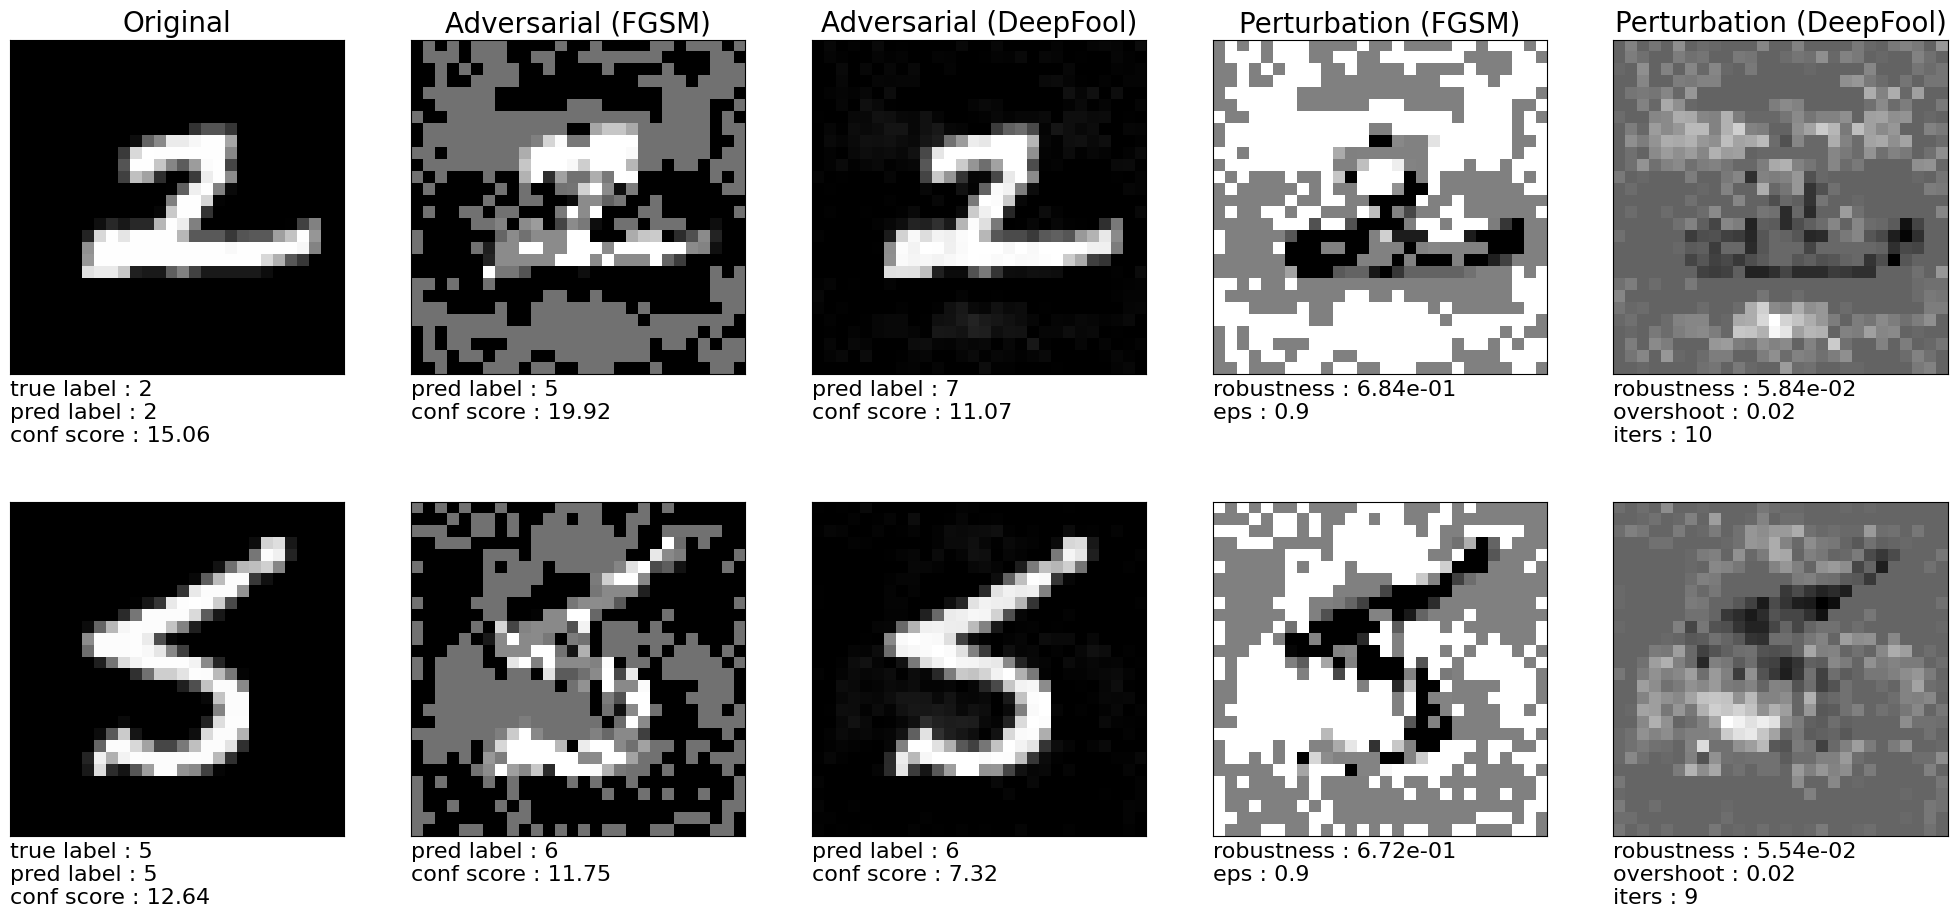

results for fsgsm_eps = 10:


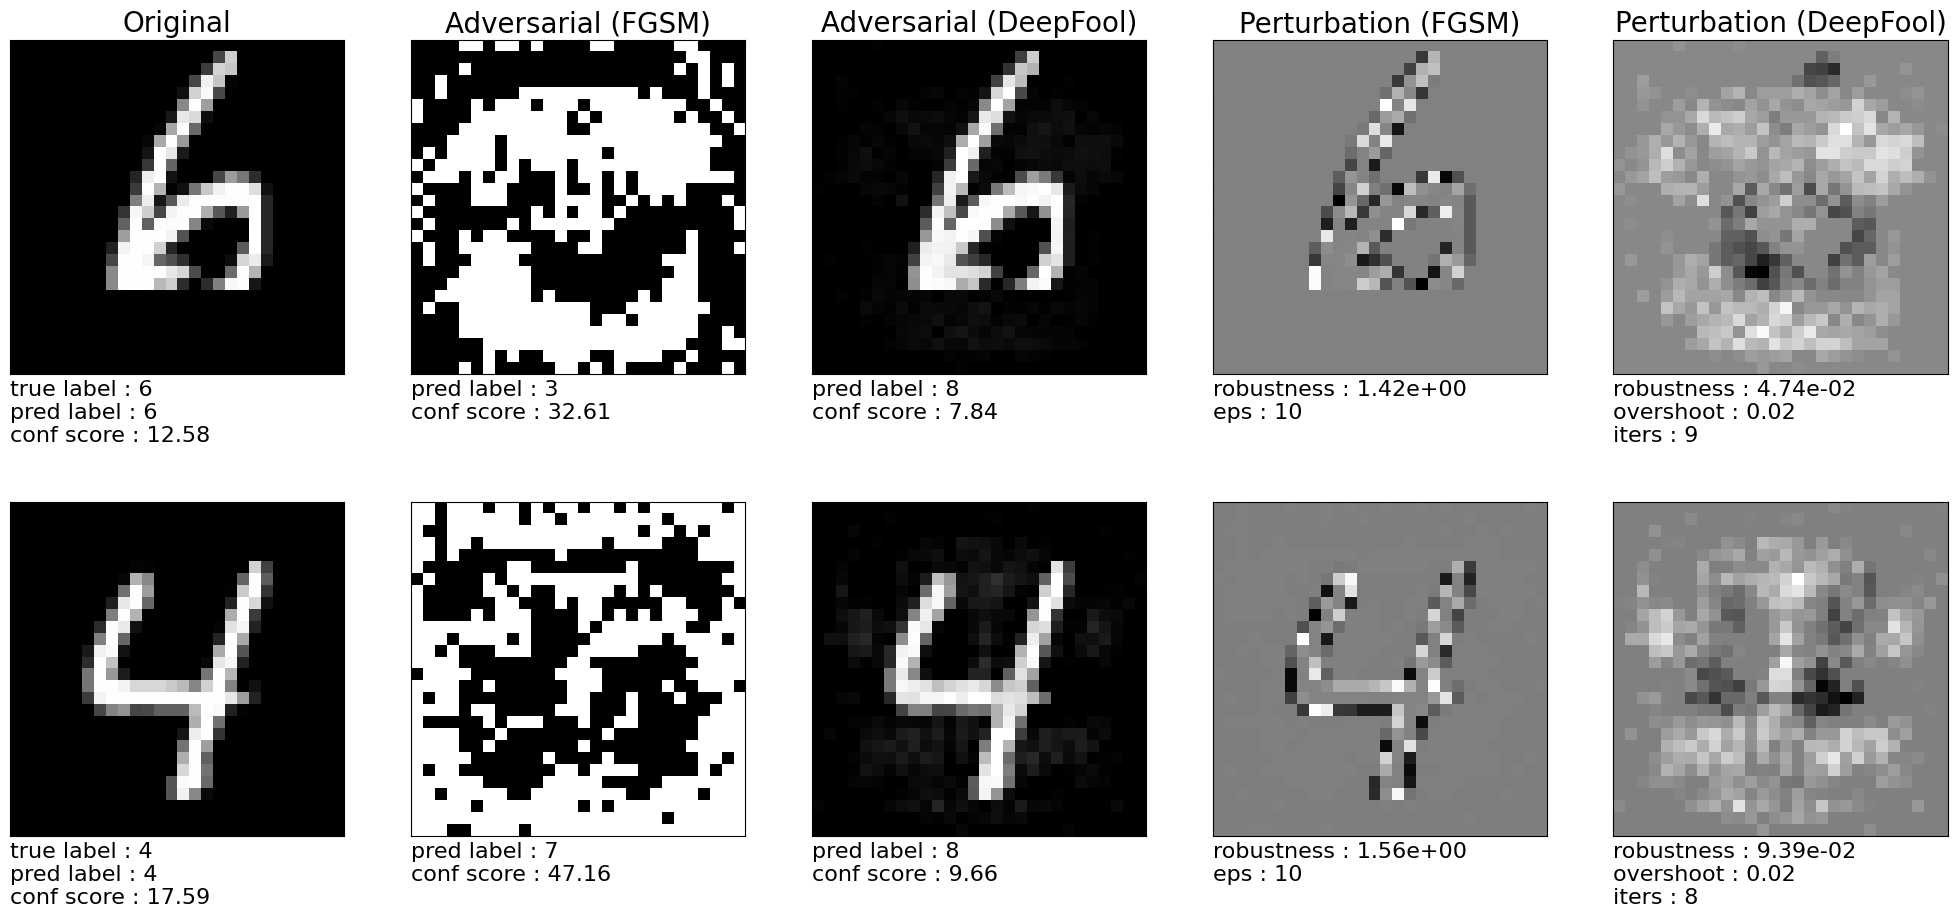

In [ ]:
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
    print(f"results for fsgsm_eps = {fgsm_eps}:")
    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
    if device.type == 'cuda': torch.cuda.empty_cache()

## Network-in-Network attack example for various `eps` values

results for fsgsm_eps = 0.001:


<ipython-input-13-685e8f913d15>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


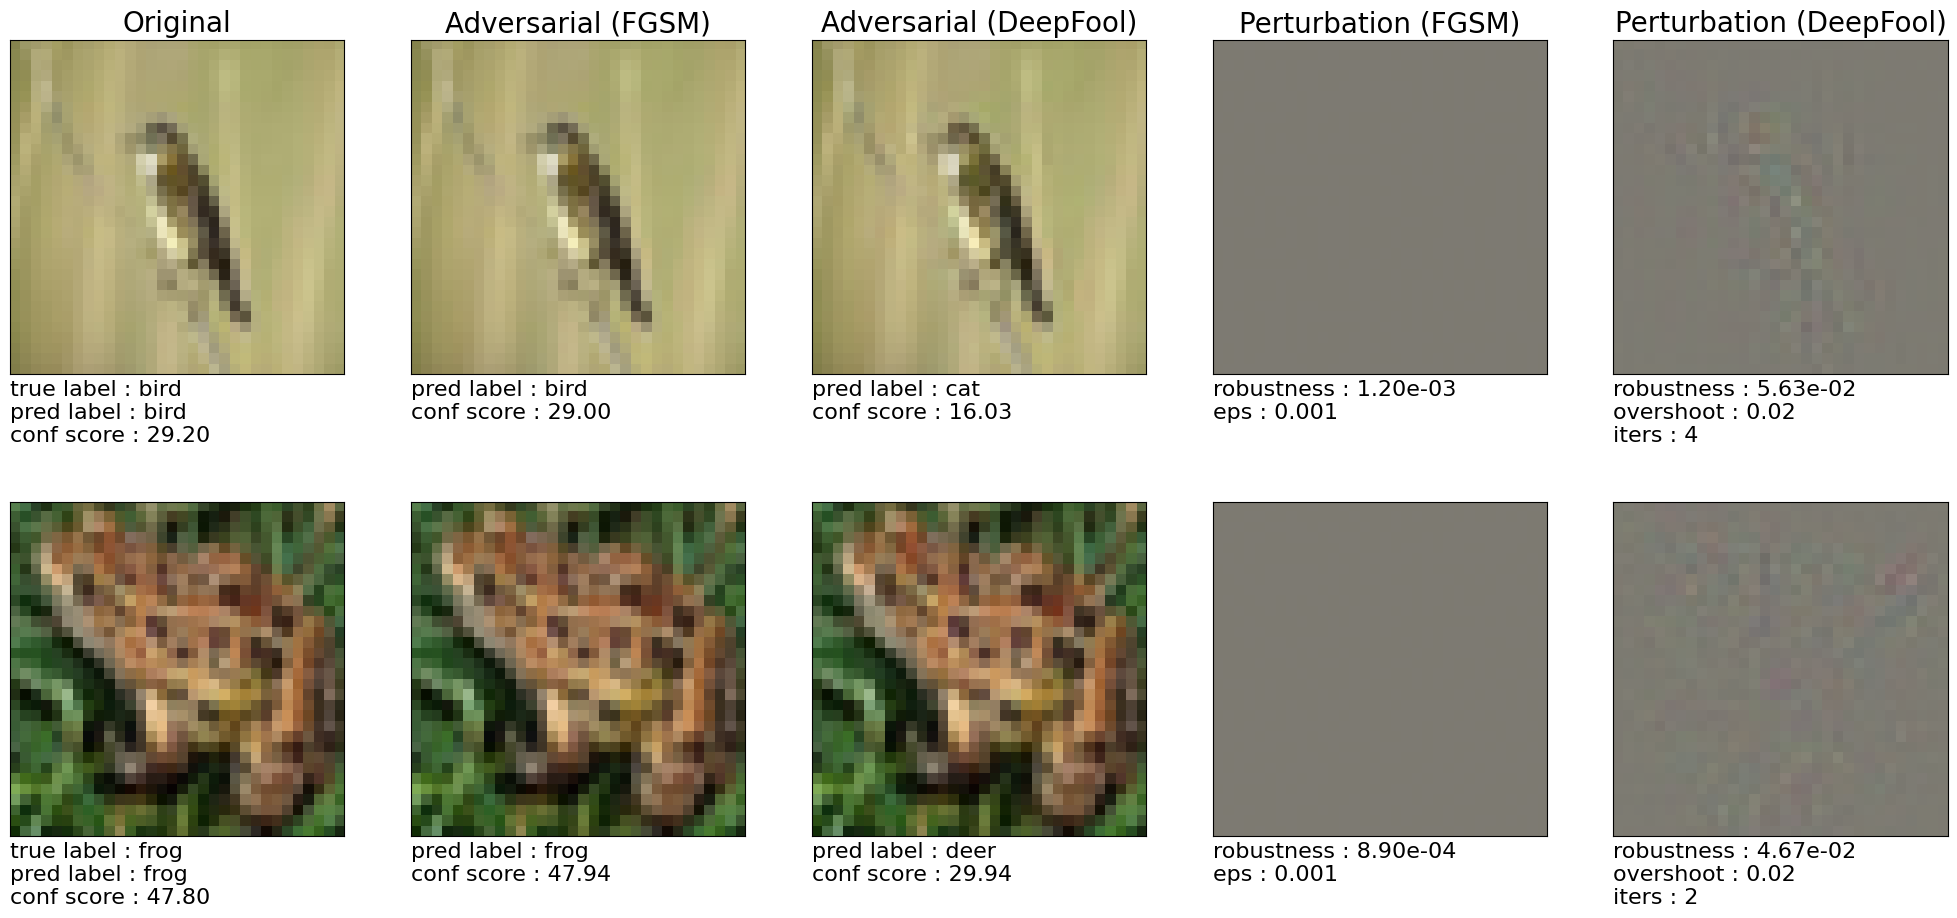

results for fsgsm_eps = 0.02:


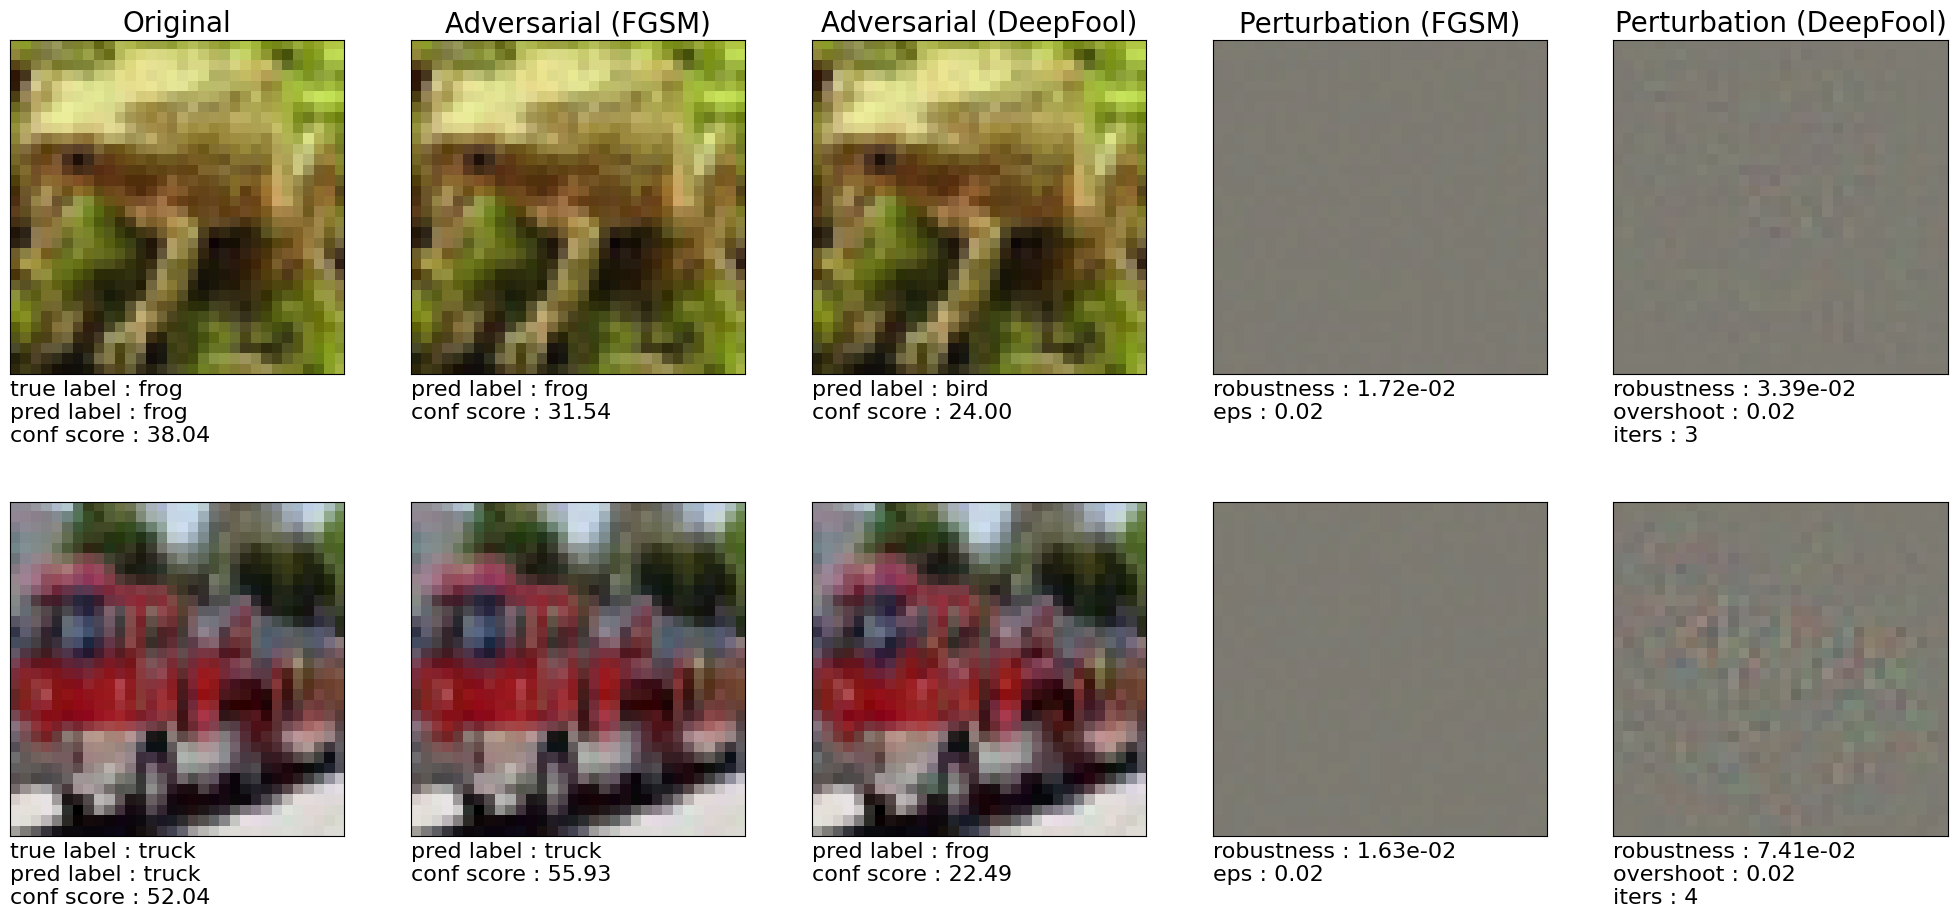

results for fsgsm_eps = 0.5:


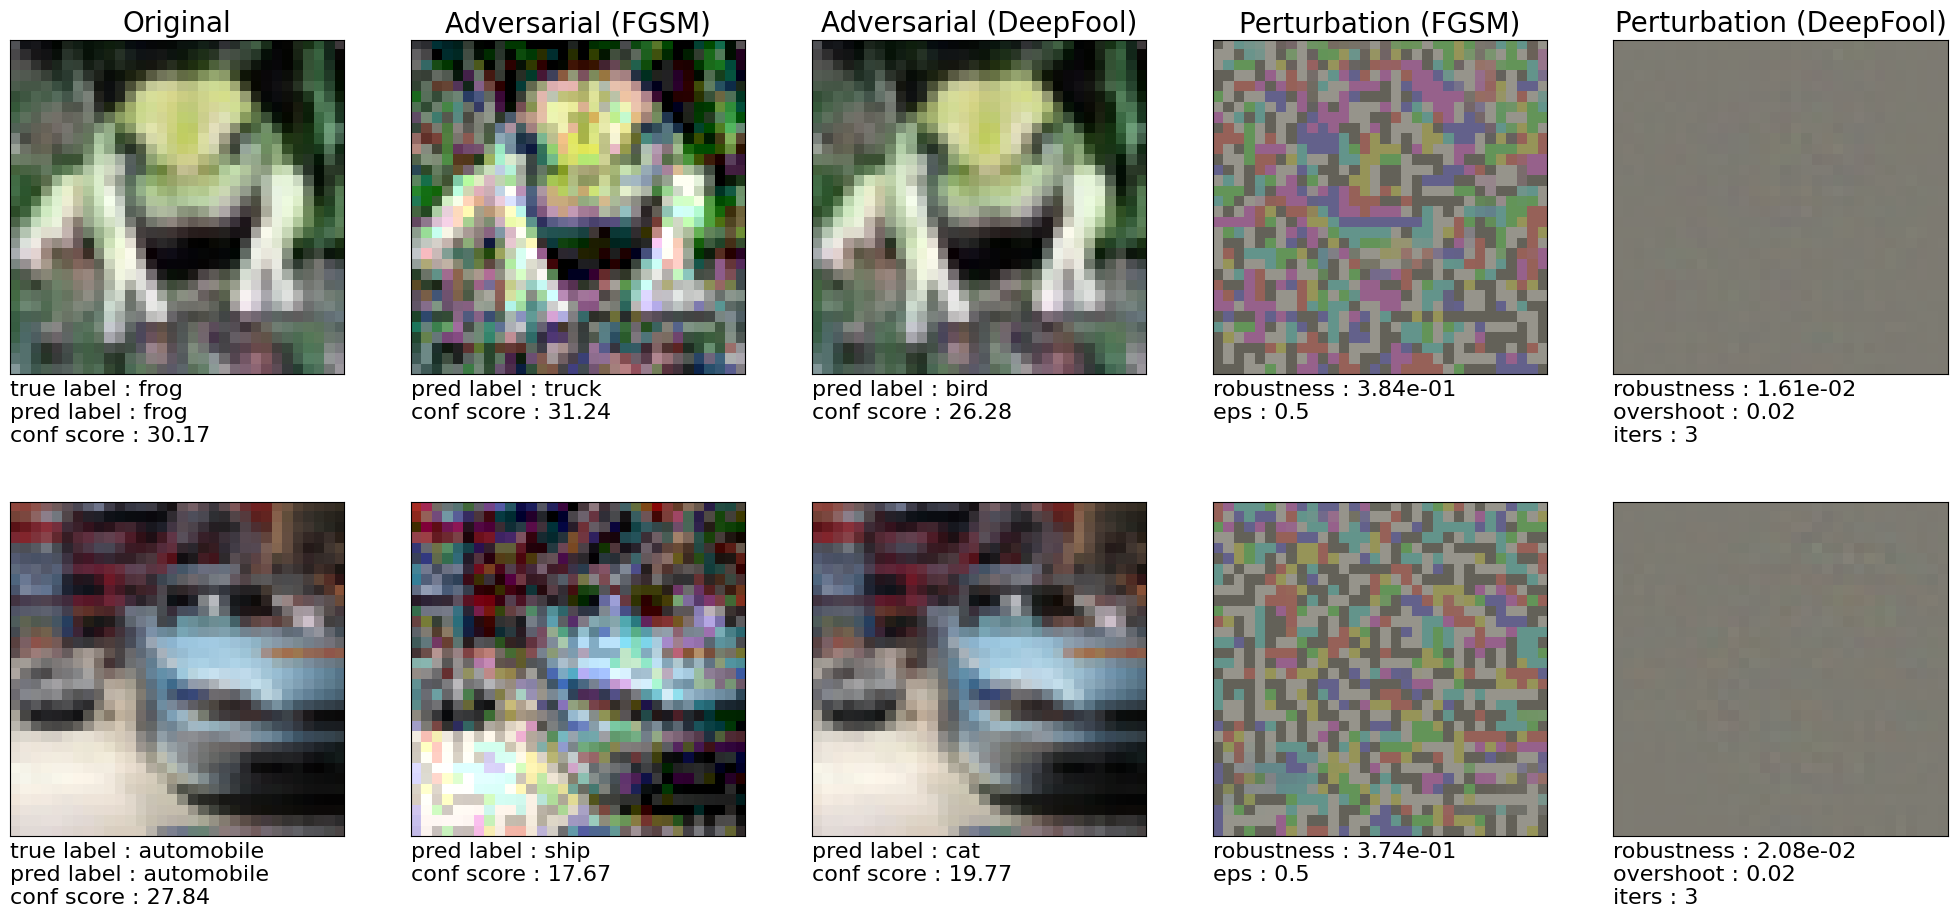

results for fsgsm_eps = 0.9:


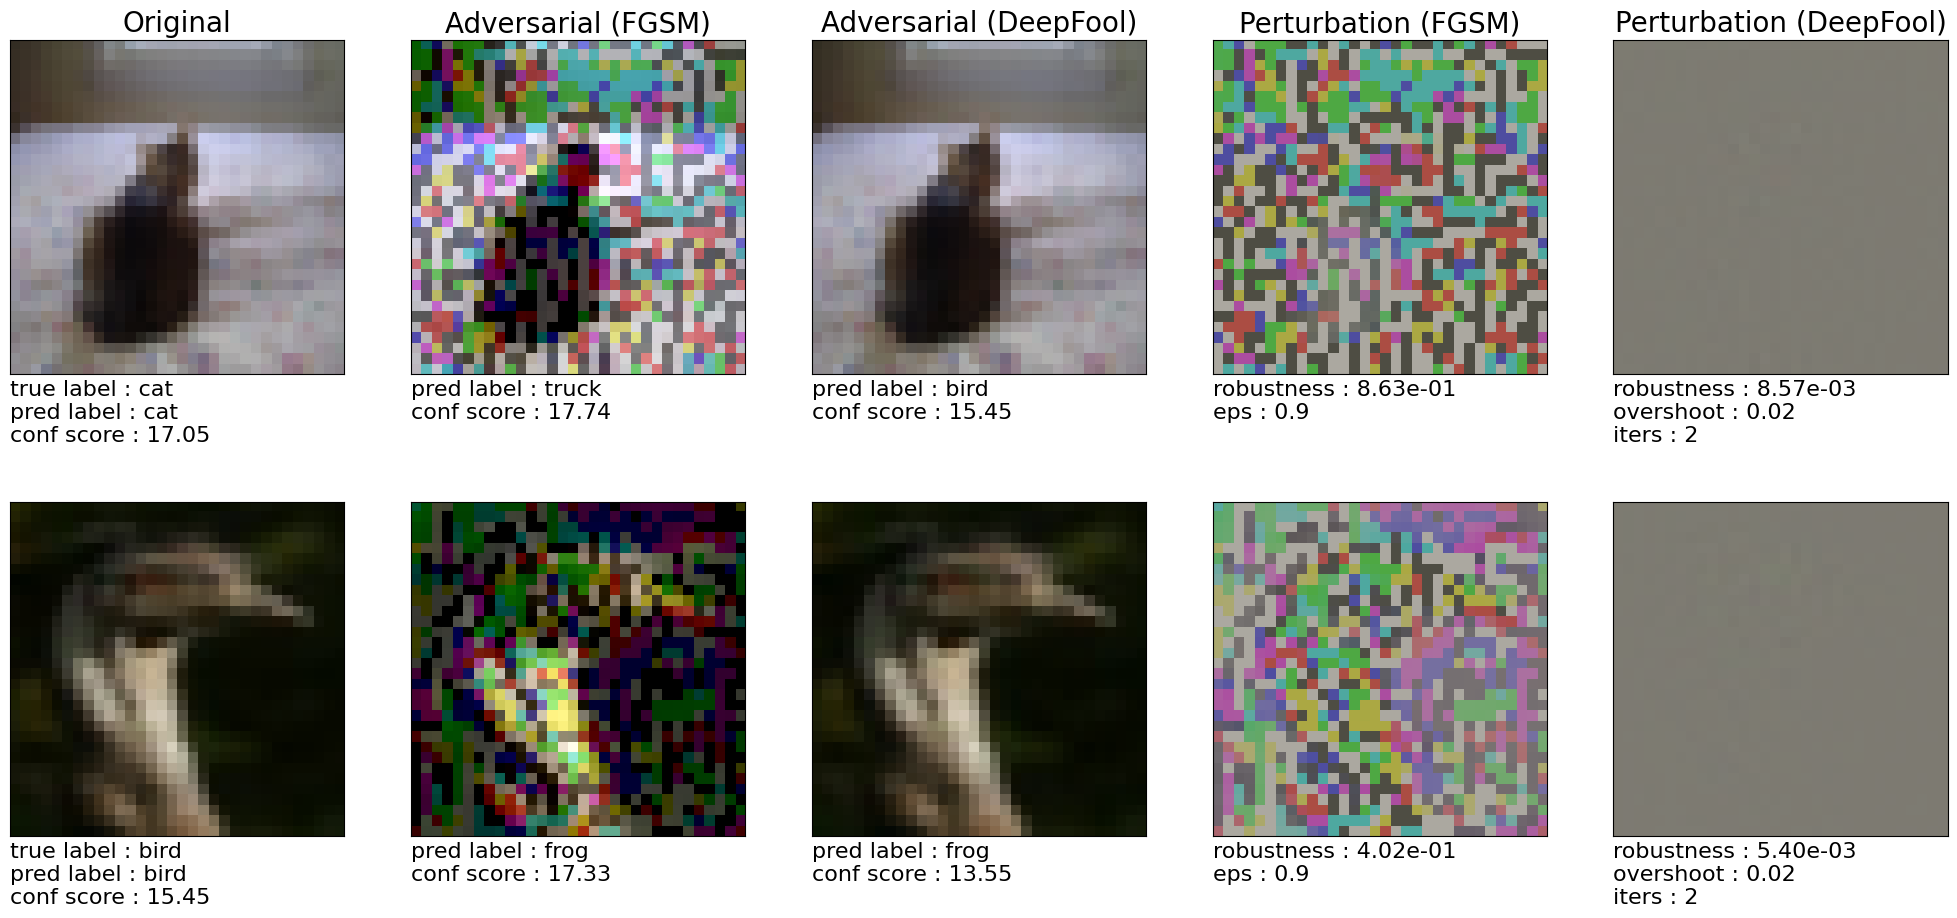

results for fsgsm_eps = 10:


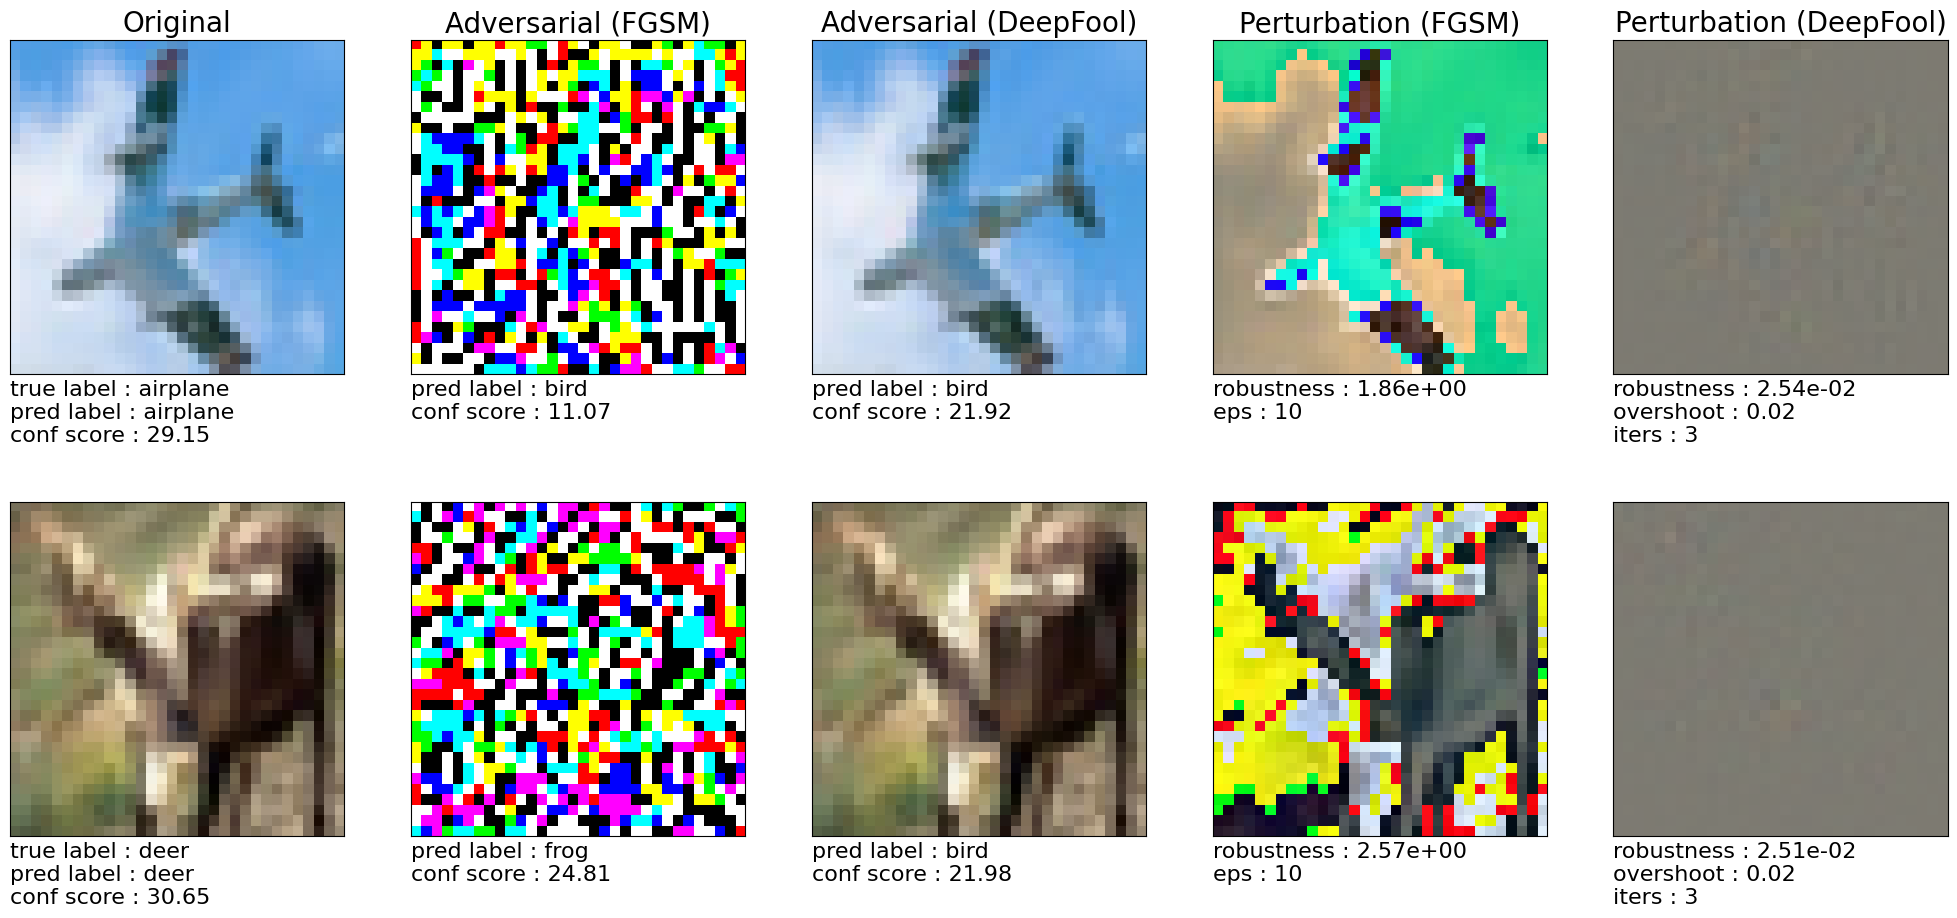

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
    print(f"results for fsgsm_eps = {fgsm_eps}:")
    display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
    if device.type == 'cuda': torch.cuda.empty_cache()

## LeNet attack example (CIFAR-10) for various `eps` values

results for fsgsm_eps = 0.001:


<ipython-input-14-5d035ec55b5c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


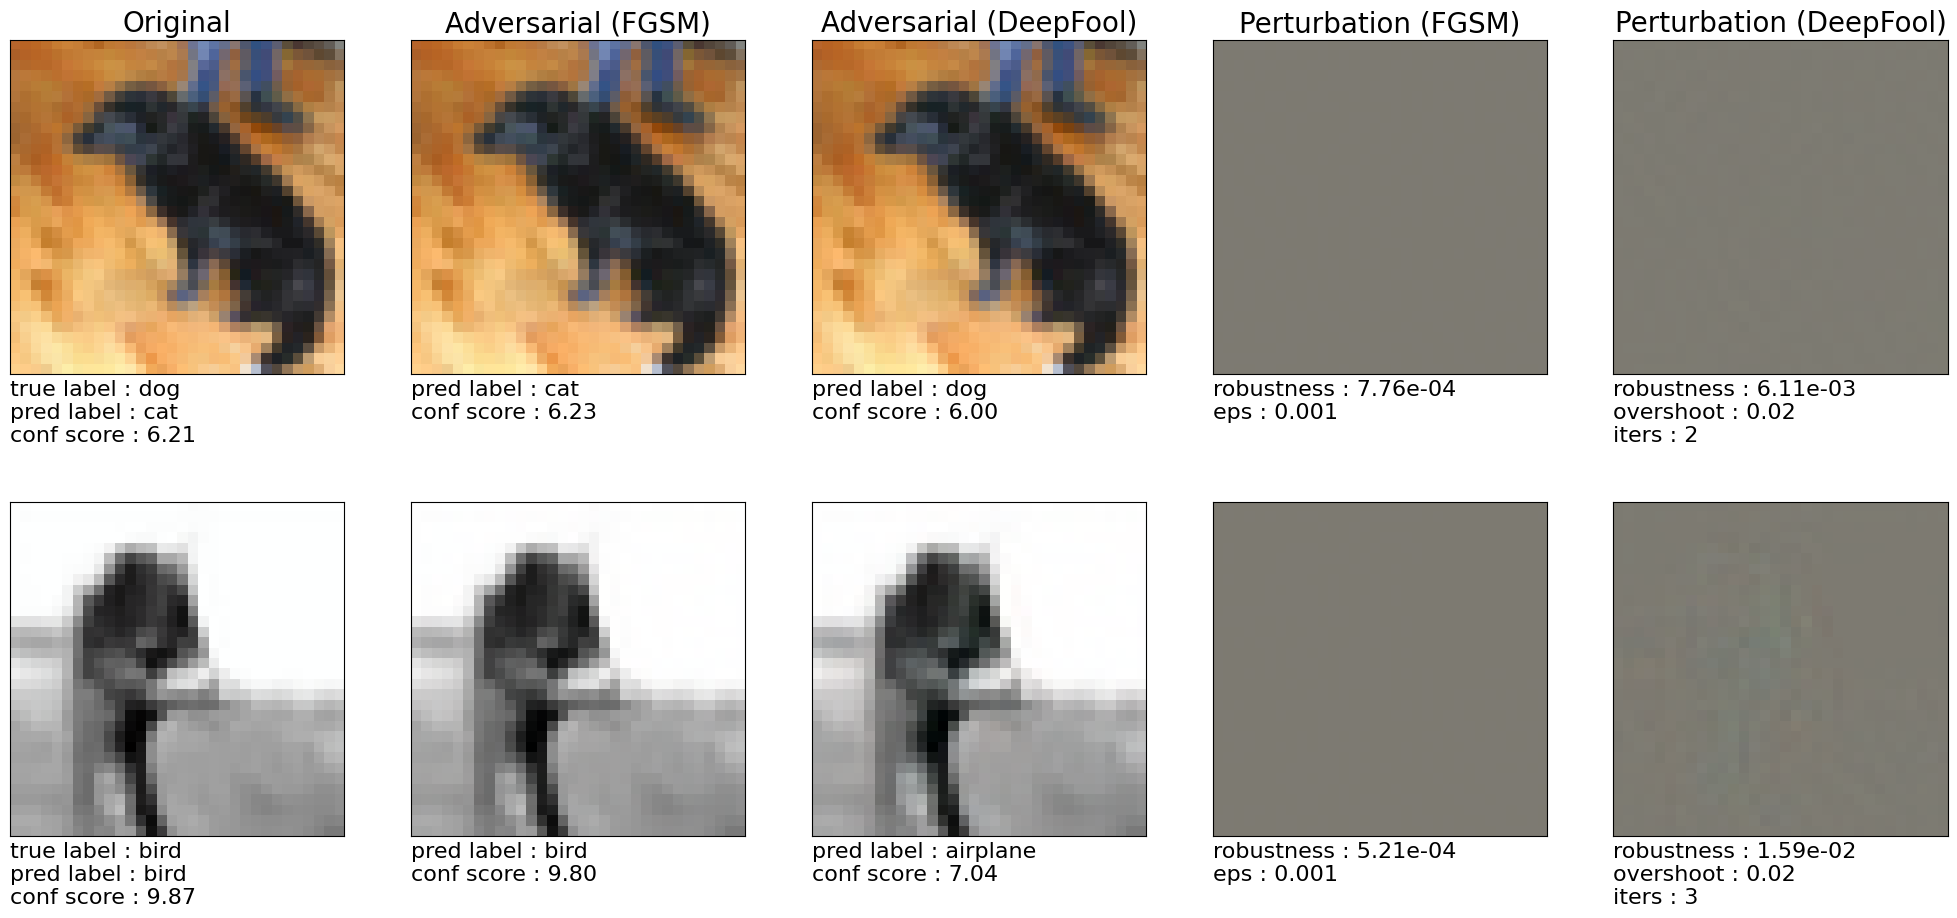

results for fsgsm_eps = 0.02:


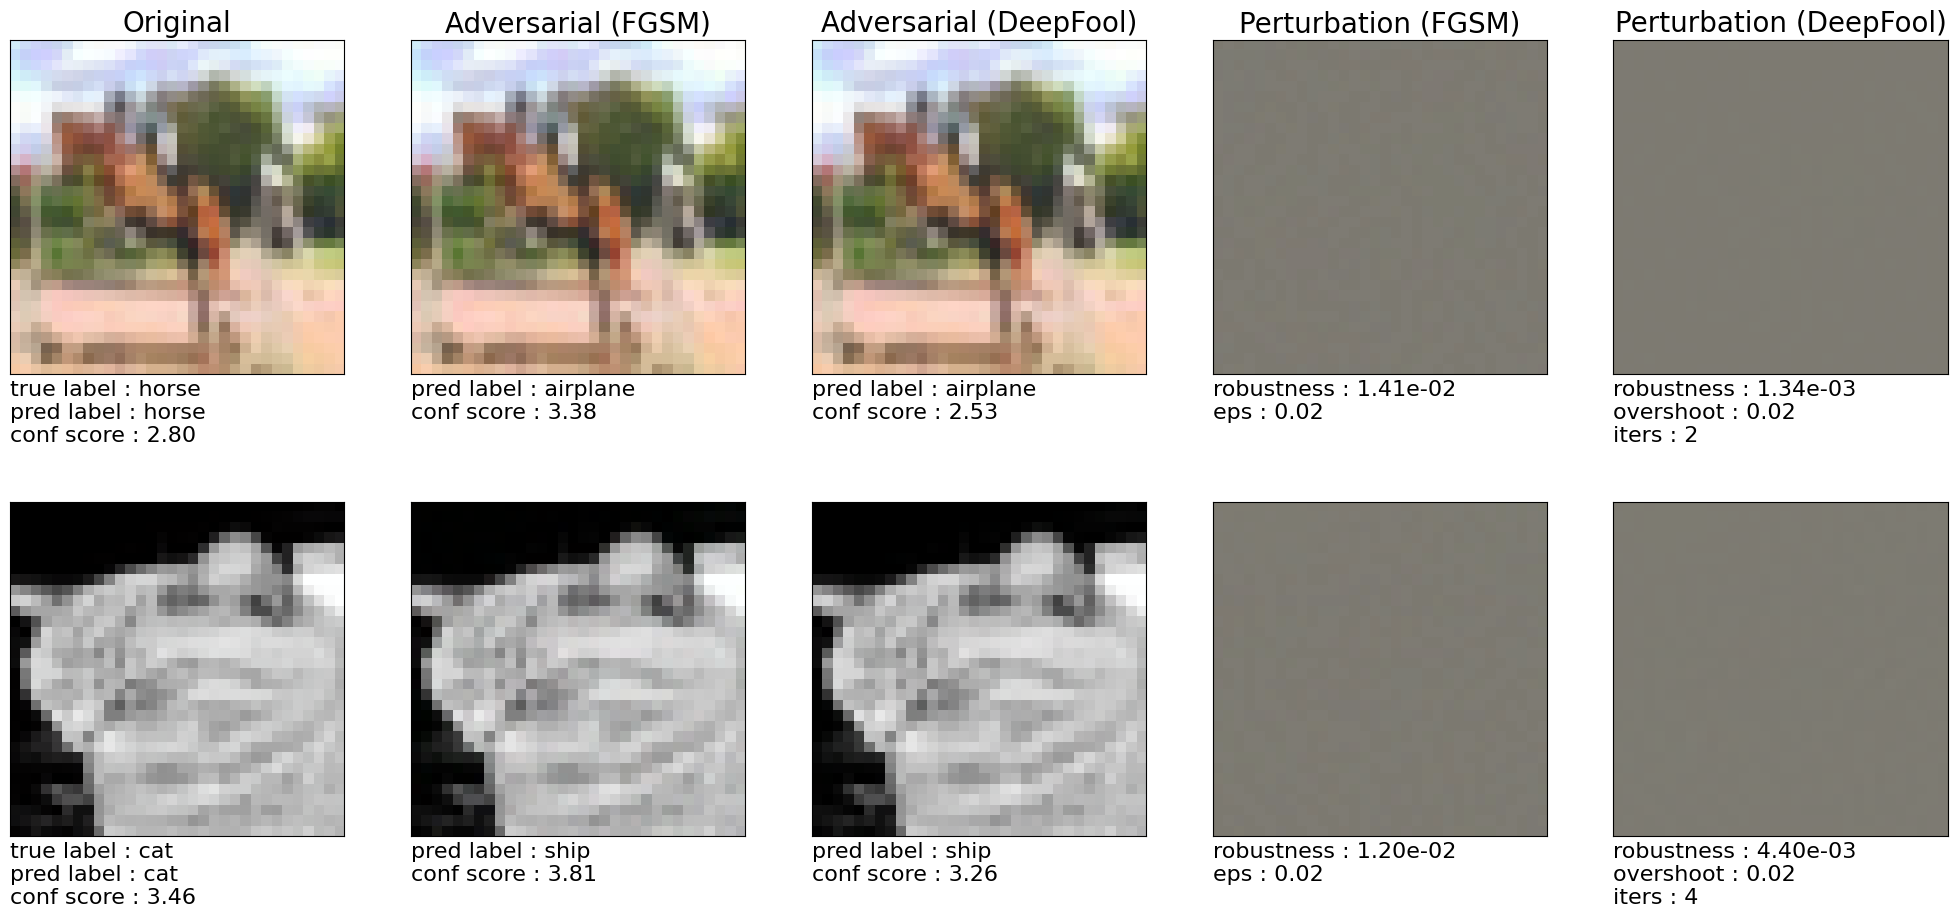

results for fsgsm_eps = 0.5:


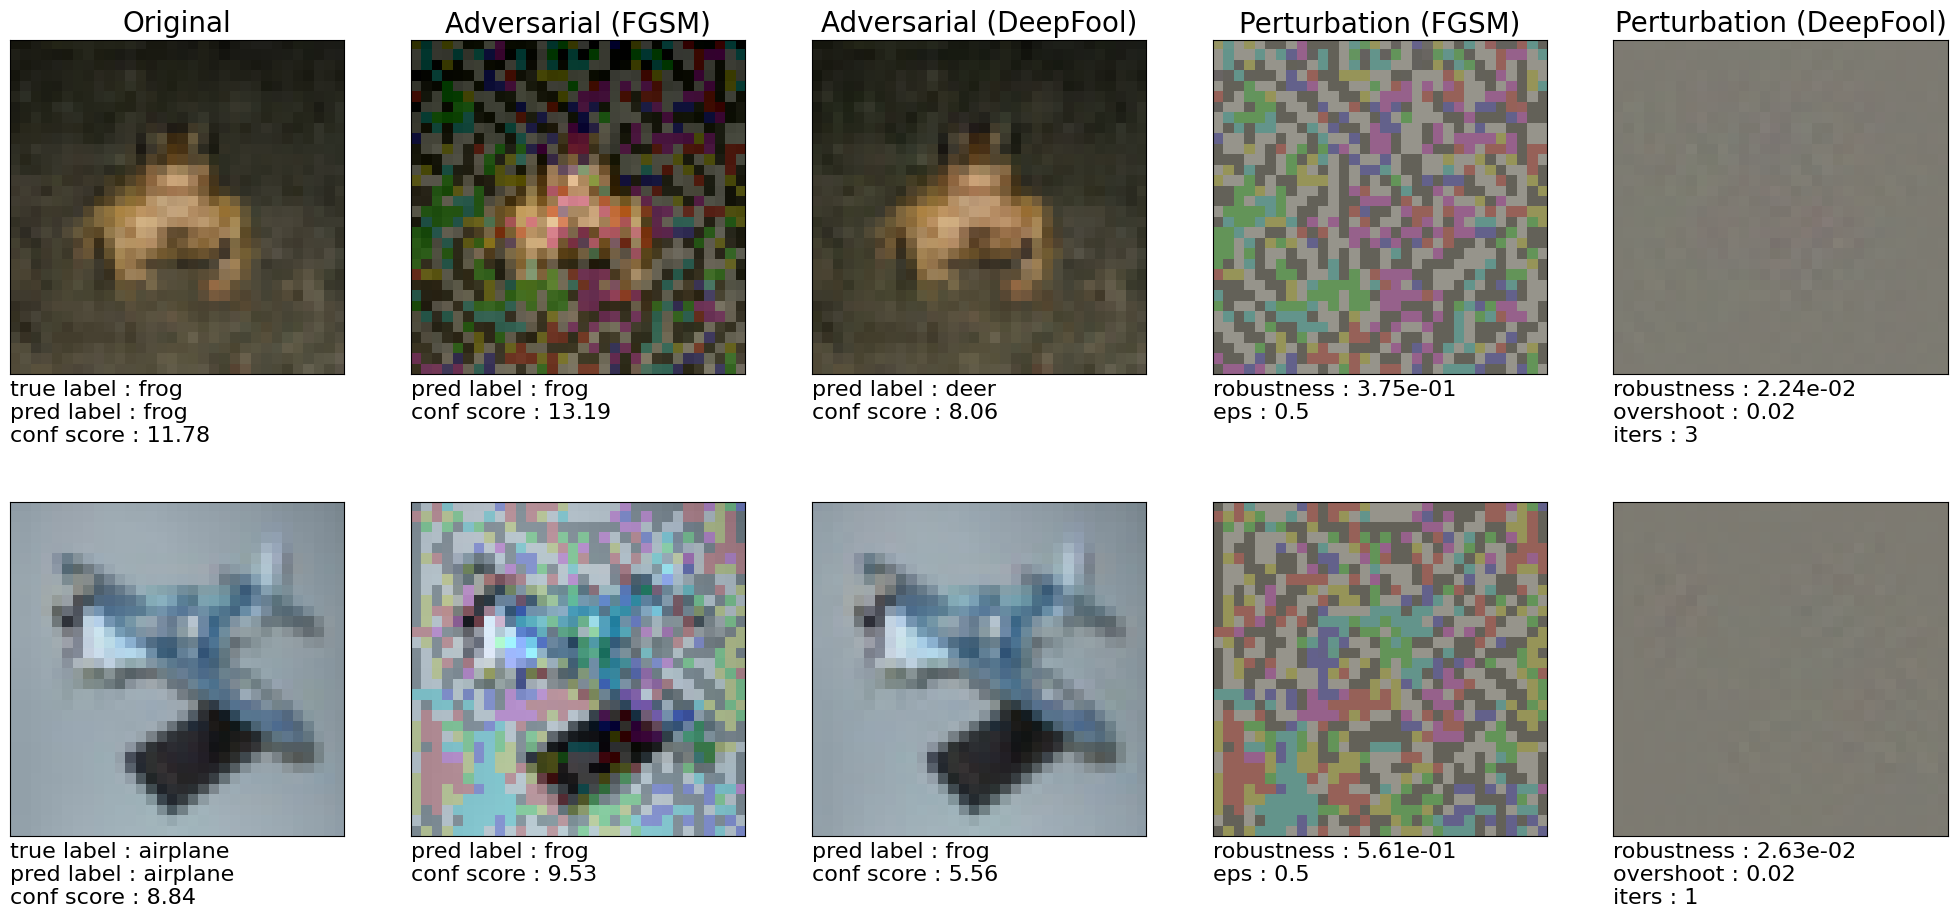

results for fsgsm_eps = 0.9:


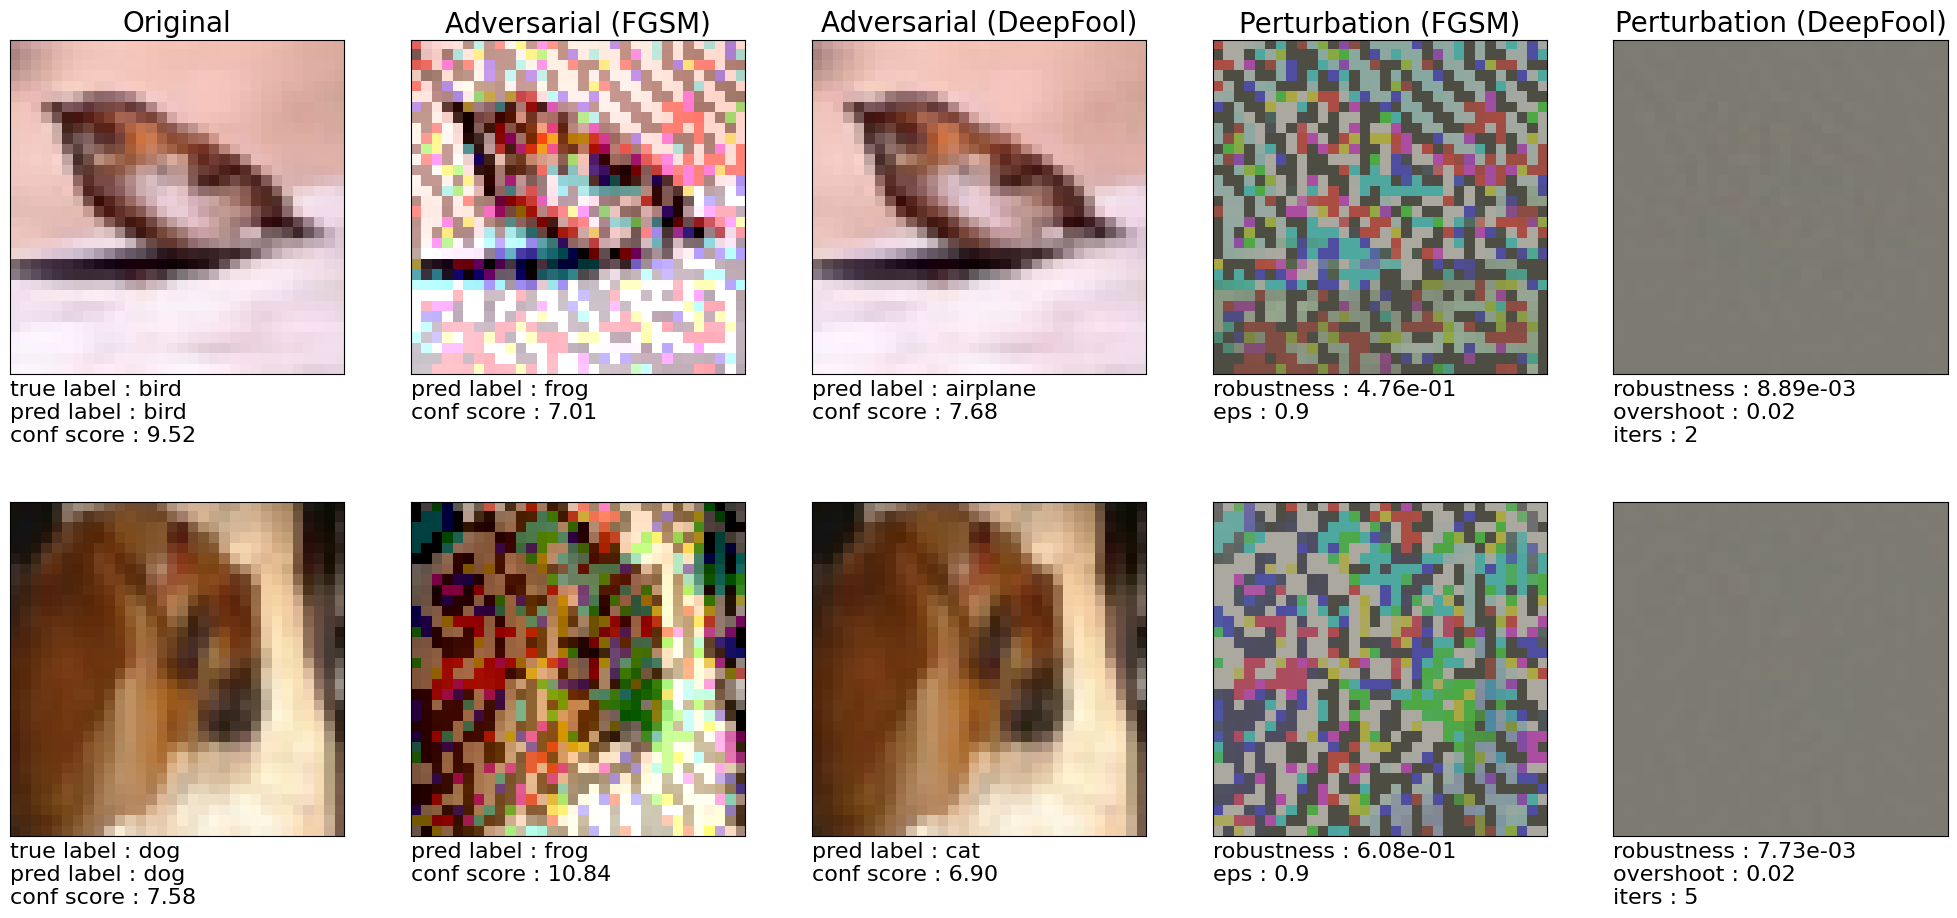

results for fsgsm_eps = 10:


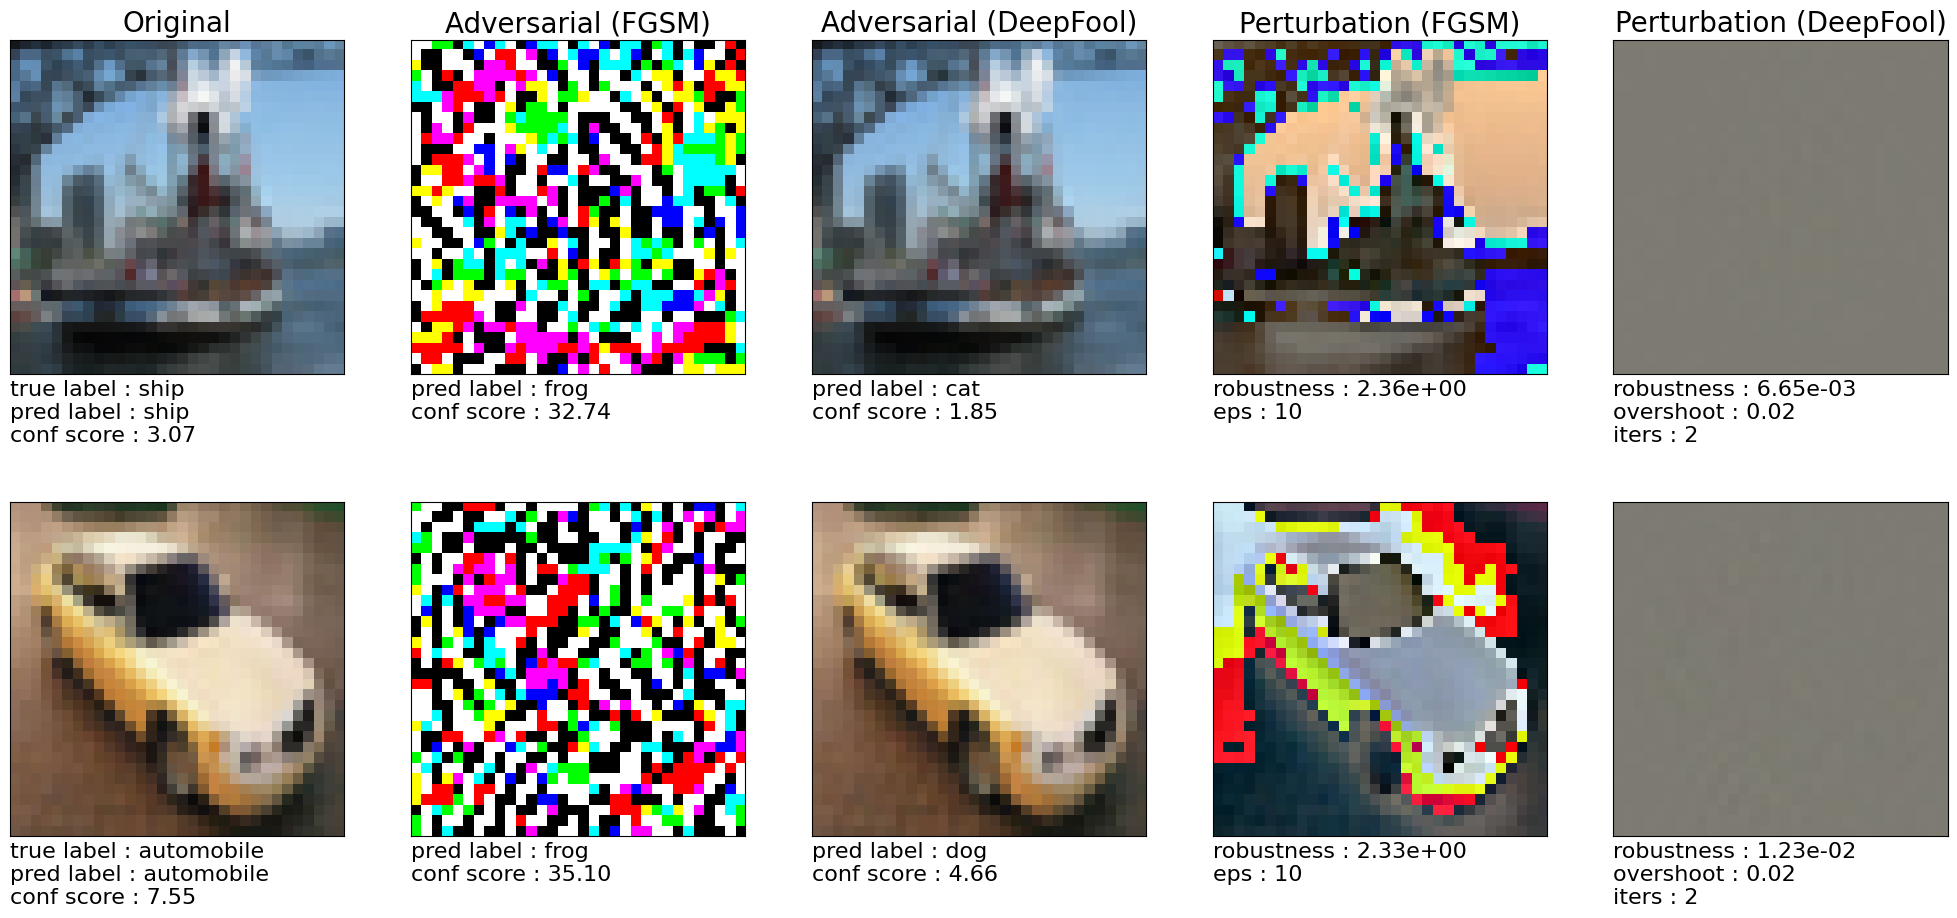

In [ ]:
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
    print(f"results for fsgsm_eps = {fgsm_eps}:")
    display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
    label_map=cifar_classes)
    if device.type == 'cuda': torch.cuda.empty_cache()

# Вывод

Значение параметра `fgsm_eps` напрямую влияет на результаты и успешность атаки FGSM. В частности, чем выше значение параметра, тем сильнее искажается изображение, что приводит к неверным предсказаниям моделей.

На диапазоне значений `0.001, 0.02, 0.5, 0.9, 10`, модели показывают следующие результаты:
- LeNet + MNIST начинает давать ложные предсказания на значении `0.02`;
- FC + MNIST аналогично;
- NiN + CIFAR начинает давать ложные предсказания на значении `0.5`;
- LeNet + CIFAR на значении `0.02`.

На основе этого можно сделать вывод, что модель NiN наиболее устойчива к атаке FGSM.